# Projeto Integrado CDIA5 - Grupo 3
# Sistema de Arquivo Distribuídos - HDFS e PySpark
# Objetivo de Negócio:

Somos uma empresa que pretende realizar uma campanha de vendas voltada para mulheres de 18 a 40 anos, com foco na venda de máscaras de argila. Como parte da nossa equipe de marketing, conduzimos um estudo abrangente sobre o tema, a fim de identificar os melhores sites para anunciar nossos produtos.

Para isso, utilizamos técnicas avançadas de análise, como web scraping para coleta de dados na web e o pyspark para realizar a contagem de palavras. Com base nessa análise, nosso objetivo é selecionar os 5 melhores sites entre os 20 inicialmente considerados, nos quais iremos direcionar nossos anúncios.

Além disso, faremos a coleta de dados em uma rede social e realizaremos uma análise para compreender quais sites estão mais alinhados com os comentários e interesses do nosso público-alvo. Essa análise nos permitirá direcionar nossas estratégias publicitárias de forma mais efetiva, engajando nossa audiência e impulsionando as vendas dos nossos produtos voltados para cuidados com a pele.

# Coletando dados do Facebook

Para podermos usar o Facebook é necessário ter uma conta, caso contrario conseguimos visualizar apenas uma publicação de cada vez, para resolver esse problema uma conta foi criada para podermos acessar os dados sem mais problemas, essa conta não pertence a ninguém especifico e foi criada apenas para fins da realização desse trabalho.
A url fornecida nos levara diretamente para a área destina a publicações relacionas a máscaras de argila.

In [1]:
#Importações
from selenium import webdriver
import time
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import os

In [2]:
#Credenciais para acessar o facebook
fb_url = "https://www.facebook.com/search/posts/?q=mascara%20de%20argila&__tsid__=0.5023192808728404&__epa__=SERP_TAB&__eps__=SERP_POSTS_TAB"

user = "yadoji2440@mevori.com"
pw = "mevori.com@yadoji2440"

In [3]:
chrome_options = webdriver.ChromeOptions()
prefs = {"profile.default_content_setting_values.notifications" : 2}
chrome_options.add_experimental_option("prefs",prefs)

driver = webdriver.Chrome(chrome_options=chrome_options)
driver.get(fb_url)
time.sleep(2)
elem = driver.switch_to.active_element
elem.send_keys(user)
elem.send_keys(Keys.TAB)
time.sleep(3)
elem = driver.switch_to.active_element
elem.send_keys(pw)
elem.send_keys(Keys.ENTER)
time.sleep(5)
driver.get(fb_url)
time.sleep(3)

posts = []
old_posts_len = -1
i = 1
while len(posts) > old_posts_len:
    attr = 'data-ad-preview="message"'
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    old_posts_len = len(posts)
    posts = driver.find_elements(By.XPATH, f'//div[@{attr}]')
    time.sleep(1)
    novos_posts = len(posts) - old_posts_len
    #print(f"encontrados {novos_posts} novos posts")
    for post in posts[old_posts_len::]:
        attr = 'role="button"'
        for button in post.find_elements(By.XPATH, f'//div[@{attr}]'):
            if button.text.strip() == "Ver mais":
                #print("clicando no ver mais")
                driver.execute_script("arguments[0].click();", button)
                break
        time.sleep(2)
        with open(f"fb_post_{i+1}.txt", "w", encoding="utf-8") as f:
            f.write(post.text)
        #print(post.text)
        #print(f"finalizado post {i}")
        i += 1
print(f"encontrados {len(posts)} posts")

C:\Users\positivo\AppData\Local\Temp/ipykernel_3032/3371692306.py:5: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(chrome_options=chrome_options)


encontrados 92 posts


**A aplicação pode demorar a finalizar** 

**Não desligue o computador**

Os posts da coleta inicial não são suficiente então coletaremos de uma segunda URL para complementar nosso projeto.
Uma nova URL é definida e somos direcionados para uma pagina destina a publicações relacionadas a máscara de argila facial.

Sim, os posts mudam.

In [4]:
#Definindo uma nova url
fb_url = "https://www.facebook.com/search/posts/?q=mascara%20de%20argila%20facial"
#Entrando em uma nova url
driver.get(fb_url)
time.sleep(5)

posts = []
old_posts_len = -1
while len(posts) > old_posts_len:
    attr = 'data-ad-preview="message"'
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    old_posts_len = len(posts)
    #time.sleep(1)
    posts = driver.find_elements(By.XPATH, f'//div[@{attr}]')
    time.sleep(1)
    novos_posts = len(posts) - old_posts_len
    #print(f"encontrados {novos_posts} novos posts")
    for post in posts[old_posts_len::]:
        attr = 'role="button"'
        for button in post.find_elements(By.XPATH, f'//div[@{attr}]'):
            try:
                if button.text.strip() == "Ver mais":
                    #print("clicando no ver mais")
                    driver.execute_script("arguments[0].click();", button)
                    break
            except StaleElementReferenceException:
                continue
        time.sleep(3)
        with open(f"fb_post_{i+1}.txt", "w", encoding="utf-8") as f:
            f.write(post.text)
        #print(post.text)
        #print(f"finalizado post {i}")
        i += 1
print(f"encontrados {len(posts)} posts")
driver.quit()

encontrados 88 posts


# Coletando dados de 20 sites

Criaremos uma nova pasta para salvar os sites 

In [2]:
#Criando uma nova pasta para salvar os sites
try:
    os.makedirs("sites")
except:
    pass

Existem sites que precisam de uma atenção especial em suas coletas, para isso é necessária a criação de 3 funções, as quais serão usadas como parâmetros futuramente.

In [3]:
#Função para excluir classes "divs"
def get_text_exclude_divs(container):
    elements = container.find_elements(By.XPATH, "./*")
    elements = [elem.text for elem in elements if elem.tag_name != "div"]
    return "\n".join(elements)

#Função exclusiva para o site Versatille (Exclui classes "div" e "ul")
def get_text_versatille(container):
    container = container.find_element(By.TAG_NAME, "div")
    elements = container.find_elements(By.XPATH, "./*")
    elements = [elem.text for elem in elements if elem.tag_name != "div" and elem.tag_name != "ul"]
    return "\n".join(elements).replace("LEIA TAMBÉM:", "")

#Função exclusiva para o site stealthelook (exclui classes "p" e "h2", exclui tambem tudo abaixo do "Leia mais"(Não relevante para o trabalho))
def get_text_stealthelook(container):
    elements = container.find_elements(By.XPATH, "./*")
    elements = [elem.text for elem in elements if elem.tag_name == "p" or elem.tag_name == "h2"]
    return "\n".join(elements).split("LEIA MAIS")[0]

15 site podem ser feitos de maneira simples, fornecendo a url e a Classe, Id ou Xpath que será raspada.

5 sites recebem a url e a Classe ou Xpath que contem o texto principal e uma das funções feitas acima.

In [4]:
#Urls que serão usados para análise
urls = [
    ("https://blog.vizcaya.com.br/tendencias/argiloterapia-capilar-aprenda-como-usar-argila-nos-cabelos/", By.CLASS_NAME, "eltd-post-text-inner", None),
    ("https://www.loreal-paris.com.br/argila-para-o-rosto-saiba-como-inserir-a-mascara-facial-na-sua-rotina-de-cuidados-com-a-pele#:~:text=As%20m%C3%A1scaras%20de%20argila%20devem,e%20antes%20do%20creme%20hidratante.",By.CLASS_NAME, "rich-text", None),
    ("https://terralnatural.com.br/blogs/news/mascara-de-argila", By.CLASS_NAME, "article__content", None),
    ("https://www.dermaclub.com.br/blog/todos-os-temas/argila-verde-branca-preta-como-usar-na-pele-quais-sao-os-tipos-para-que-serve-conheca-os-beneficios_a9283.html", By.CLASS_NAME, "l-blog-article__content", None),
    ("https://quintaldermocosmeticos.com.br/blogs/quintal/argila-beleza-que-vem-do-solo?psafe_param=1&gad=1&gclid=CjwKCAjwvJyjBhApEiwAWz2nLSHEs0mQehb5YPbETSbRzH8-DKBCcLmc0OplQfX_8UOgHQm1sQsPuhoCZJ8QAvD_BwE", By.CLASS_NAME, "rte", None),
    ("https://odia.ig.com.br/d-mulher/2017-01-26/argilas-para-o-rosto-fazem-drenagem-e-desintoxicam-a-pele.html", By.CLASS_NAME, "article-body", None),
    ("https://revistaquem.globo.com/QUEM-Inspira/noticia/2019/05/receita-caseira-aprenda-fazer-mascara-facial-detox-da-blogueira-mari-saad.html", By.CLASS_NAME, "protected-content", None),
    ("https://simpleorganic.com.br/blogs/simple-blog/argila-para-os-rosto-como-usar-e-diluir", By.CLASS_NAME, "Article__Content", None),
    ("https://carenb.com/blogs/beauty-journal/mascara-de-argila-saiba-como-utilizar-e-seus-beneficios", By.CLASS_NAME, "article-template", None),
    ("https://www.ecycle.com.br/limpeza-de-pele-com-argila/", By.ID, "entry-content", None),
    ("https://hidrabene.com.br/post/o-que-a-mascara-de-argila-faz-no-rosto/", By.XPATH, "//div[@class='conteudo has-text-justified']", None),
    ("https://margaridarosa.com/guia-completo-para-misturar-argilas-cores-e-oleos/", By.CLASS_NAME, "content", None),
    ("https://boxmagenta.com.br/blog/guia-da-argila/", By.CLASS_NAME, "post-content", None),
    ("https://manipurafarmacia.com.br/mascaras-de-argila-tudo-sobre-elas/", By.CLASS_NAME, "article-inner", None),
    #Sites que precisam de mais atenção
    ("https://boaforma.abril.com.br/beleza/a-beleza-atraves-das-argilas/", By.CLASS_NAME, "content", get_text_exclude_divs),
    ("https://cabelo.com.br/argila-no-cabelo-veja-os-beneficios-de-usar-o-produto-no-cabelo/", By.CLASS_NAME, "entry-content", get_text_exclude_divs),
    ("https://pontodamulher.com.br/mascara-de-argila-verde", By.CLASS_NAME, "col-lg-9", get_text_exclude_divs),
    ("https://www.belezanaweb.com.br/loucas-por-beleza/como-usar-argila-no-cabelo/", By.CLASS_NAME, "post-content", get_text_exclude_divs),
    ("https://versatille.com/skin-care-3-receitas-caseiras-e-faceis-com-argila-e-oleos-essenciais/", By.CLASS_NAME, "edgtf-post-text", get_text_versatille),
    ("https://stealthelook.com.br/argila-no-cabelo-quais-sao-os-beneficios-e-como-usar-cada-uma-delas/", By.XPATH, "//main/article", get_text_stealthelook),
]

Nessa celula está sendo realizadas as operações de automação usando a biblioteca Selenium WebDriver.
Usaremos o Chrome como navegador.

In [5]:
#Operação automatizada usando Selenium WebDriver
driver = webdriver.Chrome() #Abre um Chrome vazio
for index, url in enumerate(urls): #Enumera as urls
    driver.get(url[0]) #Começa o processo apartir da url 0
    time.sleep(3)
    if url[3] is not None: #Para as urls que necessitam funções
        text = url[3](driver.find_element(url[1], url[2]))
    else: #Se a url não usar função simplesmente extrai o texto usando o seletor url[1] e ur[2]
        text = driver.find_element(url[1], url[2]).text
    with open(f"sites/site{index+1}_content.txt", "w", encoding="utf-8") as f:
        f.write(text)#salva o texto extraído
    time.sleep(3)

driver.quit() #Fecha o navegador e encerra a instância do WebDriver.

Cada site visitado será salvo como arquivos txt's separadamente no diretório onde o arquivo está salvo.
**A aplicação pode levar um longo tempo para ser finalizada.**

# Juntando os arquivos txt

Antes de realizarmos todo o processo PySpark para contagem de palavras precisamos juntar todos os arquivos txt coletados do facebook em um único, para isso usaremos o comando abaixo que juntará todos os arquivos txt's localizados na pasta que o caderno está.

In [6]:
copy fb*.txt merged_fb.txt

fb_post_10.txt
fb_post_100.txt
fb_post_101.txt
fb_post_102.txt
fb_post_103.txt
fb_post_104.txt
fb_post_105.txt
fb_post_106.txt
fb_post_107.txt
fb_post_108.txt
fb_post_109.txt
fb_post_11.txt
fb_post_110.txt
fb_post_111.txt
fb_post_112.txt
fb_post_113.txt
fb_post_114.txt
fb_post_115.txt
fb_post_116.txt
fb_post_117.txt
fb_post_118.txt
fb_post_119.txt
fb_post_12.txt
fb_post_120.txt
fb_post_121.txt
fb_post_122.txt
fb_post_123.txt
fb_post_124.txt
fb_post_125.txt
fb_post_126.txt
fb_post_127.txt
fb_post_128.txt
fb_post_129.txt
fb_post_13.txt
fb_post_130.txt
fb_post_131.txt
fb_post_132.txt
fb_post_133.txt
fb_post_134.txt
fb_post_135.txt
fb_post_136.txt
fb_post_137.txt
fb_post_138.txt
fb_post_139.txt
fb_post_14.txt
fb_post_140.txt
fb_post_141.txt
fb_post_142.txt
fb_post_143.txt
fb_post_144.txt
fb_post_145.txt
fb_post_146.txt
fb_post_147.txt
fb_post_148.txt
fb_post_149.txt
fb_post_15.txt
fb_post_150.txt
fb_post_151.txt
fb_post_152.txt
fb_post_153.txt
fb_post_154.txt
fb_post_155.txt
fb_post_156.tx

Aqui juntaremos apenas os arquivos da pasta sites

In [7]:
copy sites\*.txt sites\merged_sites.txt

sites\site10_content.txt
sites\site11_content.txt
sites\site12_content.txt
sites\site13_content.txt
sites\site14_content.txt
sites\site15_content.txt
sites\site16_content.txt
sites\site17_content.txt
sites\site18_content.txt
sites\site19_content.txt
sites\site1_content.txt
sites\site20_content.txt
sites\site2_content.txt
sites\site3_content.txt
sites\site4_content.txt
sites\site5_content.txt
sites\site6_content.txt
sites\site7_content.txt
sites\site8_content.txt
sites\site9_content.txt
        1 arquivo(s) copiado(s).


# Contando palavras com o PySpark

In [8]:
#Instalando a biblioteca
#!pip install pyspark py4j
#!pip install unidecode
#Importações

from pyspark.sql import SparkSession
from pyspark.sql.functions import split
from pyspark.sql.functions import explode, col
from pyspark.sql.functions import lower
from pyspark.sql.functions import regexp_extract
from pyspark.ml.feature import StopWordsRemover
from nltk.corpus import stopwords
from nltk import ngrams
import nltk
from unidecode import unidecode
from collections import Counter
import csv


nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\positivo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\positivo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Inicimos uma sessão spark como o nome "Máscara_de_argila_Grupo3" para que possamos utilizar o Spark.

In [9]:
#Iniciando uma sessão no Spark
spark = SparkSession \
          .builder \
          .appName("Máscara_de_argila_Grupo3") \
          .getOrCreate()


spark

Aqui temos uma lista de palavras que não estão no stopwords e precisão ser definidas manualmente.

In [10]:
#Removendo palavras desnecessárias
custom_stopwords = stopwords.words("portuguese")
custom_stopwords.extend(['r', 'nao', 'uso', 'pra', 'ja', 'voce', 'sao', 'disso', 'usar', 'pode', 'assim', 'outras', 'tambem', 'alem', 'fazer', 'vale', 'dia', 'fazer', 'qualquer', 'durante', 'bem', 'antes', 'ainda', 'poucos', 'passo', 'report', 'this',
                        'opcao', 'pouco', 'seguinte', 'melhor', 'alguns', 'versoes', 'deixar', 'extra', 'eliminar', 'incluir', 'toda', 'aplicar', 'ajuda', 'horas', 'fique', 'mal', 'deixando', 'tratamento', 'dewy', 'dar', 'etapa', 'ad', 'Navegação',
                        'quis', 'so', 'proporcional', 'receber', 'preferem', 'minutinhos', 'levam', 'quanto', 'vai', 'conta', 'deixam', 'ter', 'saiba', 'precisam', 'porque', 'tanto', 'agir', 'perder', 'enquanto', 'nunca', 'indicada', 'de', 'artigos',
                        'precisa', 'todas', 'aprenda', 'versao', 'passo', 'preparacao', 'manha', 'descansa', 'regiao', 'pesada', 'proporcional', 'noite', 'diaria', 'sair', 'permitir', 'coisas', 'muitos', 'lembrar', 'escolher', 'passar', 'Author', 'By',
                        'tomando', 'dormidas', 'opcao', 'ocasiao', 'iserir', 'ficando', 'marco', 'falar', 'ouviu', 'descobrir', 'saber', 'hoje', 'ficaram', 'outros', 'varios', 'usadas', 'certeza', 'excesso', 'dias', 'existem', 'concentracao', 'suave',
                        'levemente', 'nada', 'ficar', 'fica', 'conhecidas', 'causa', 'serve', 'usada', 'quer', 'caso', 'sentir', 'tipo', 'vez', 'preciso', 'esqueca', 'devem', 'evitar', 'contem', 'devo', 'geral', 'acao', 'tao', 'ate', 'todos', 'varias',
                        'podem', 'confira', 'cada', 'tipos', 'utiliza', 'sendo', 'utilizado', 'portanto', 'dessa', 'gente', 'duas', 'fins', 'gostou', 'parte', 'seguir', 'otima', 'diferem', 'proximo', 'ha', 'ah', 'ok', 'util', 'passos', 'vao', 'deve',
                        'ai', 'entram', 'tantas', 'acordo', 'dra', 'curi', 'tera', 'neste', 'veja', 'desses', 'atras', 'funcao', 'outro', 'link', 'algum', 'filtro', 'utilizam', 'crm', 'quais', 'deixe', 'devemos', 'sp', 'paulo', 'usou', 'deste', 'tudo',
                        'ne', 'algumas', 'vem', 'aqui', 'onde', 'nesse', 'parar', 'vir', 'ninguem', 'boa', 'toa', 'rio', 'si', 'volta', 'nano', 'post', 'la', 'fim', 'diz', 'causas', 'definir', 'promovendo', 'leia', 'procure', 'adicao', 'fixa', 'utilizadas',
                        'zenna', 'nenhum', 'dica', 'apos', 'c', 'deixa', 'nessa', 'piraja', 'outra', 'ano', 'ir', 'disse', 'quiser', 'sul', 'entao', 'tirar', 'alguem', 'nele', 'menos', 'nenhuma', 'quase', 'estao', 'lado', 'rua', 'apenas', 'opcoes', 'usa',
                        'ira', 'vote', 'ver', 'tiago', 'sabe', 'inves', 'vico', 'nu', 'va', 'stephanie', 'todo', 'siga', 'aloe', 'erick', 'seo', 'dizer', 'total', 'jojoba', 'ficou', 'forma', 'espere', 'obter', 'desde', 'feita', 'item', 'errar', 'algo', 'ajudar',
                        'dimas', 'itajai', 'tendo', 'bom', 'souza', 'blog', 'I', 'x', 'g', 'by', 'm', 'on', 'anne', 'ago', 'mm', 'louise', 'maria', 'irao', 'evite', 'aplicada', 'forma', 'contato', 'assunto', 'atuar', 'use', 'obter', 'melhora', 'atuam', 'lance',
                        'tree', 'suellen', 'anos', 'copaiba', 'saad', 'mari', 'vezes', 'ex', 'leva', 'nisso', 'fazendo', 'cm', 'tres', 'obtidas', 'seque', 'ambas', 'deve', 'inclui', 'voltado', 'quantidade', 'melhores', 'complementar', 'controle',  'promove', 'costumo',
                        'muita', 'partir', 'traz', 'vamos', 'casa', 'ta', 'fez', 'pois', 'sobre', 'apesar', 'local', 'pb', 'ba', 'voltar', 'serem', 'deve', 'inclui', 'unica', 'nesses', 'optar', 'share', 'pois', 'feita', 'sobre', 'age', 'possui', 'atua', 'faz', 'feito',
                        'mesma', 'pre', 'serem', 'cuja', 'usado', 'epoca', 'basta', 'torna', 'acoes', 'formar', 'sobre', 'quero', 'sim', 'deve', 'vendo', 'confia', 'serio', 'fazem', 'refere', 'escolher', 'tratar', 'atua', 'possivel', 'modo', 'aplicacao', 'indicao','traga',
                        'possui', 'casos', 'tal', 'recomenda', 'conte', 'principalmente', 'tida', 'maior', 'span', 'atencao', 'principais', 'aprender', 'hidden', 'misture', 'ajudando', 'ultrapassando', 'entanto', 'profunda', 'formas', 'aplique', 'possibilidade', 'experimentou',
                        'pratica', 'width', 'trata', 'inline', 'conhcidas', 'apesar', 'evitando', 'alguma', 'hora', 'obter', 'ideia', 'atuacao', 'avaliar', 'recomendacao', 'adepta', 'class', 'questoes', 'sempre', 'vimos', 'ohmymag', 'ligada', 'realmente', 'achou', 'px', 'odaban',
                        'controle', 'saiba', 'chamada', 'quebra', 'utiliada', 'equilibrar', 'line', 'passaram', 'sobre', 'manter', 'teor', 'intenso', 'mexa','recurso', 'derivados', 'melhorar', 'tratar', 'retirar', 'area', 'preparar', 'aproveitar', 'sentem', 'aplique', 'espere', 
                        'leve', 'excessiva', 'leves', 'semana', 'finais', 'conheca', 'sugestoes', 'remova', 'meio', 'aplicada', 'tratar', 'vidal', 'expert', 'explica', 'carla', 'feita', 'aplicacao', 'deve', 'minutos', 'exposicao', 'continua', 'estruturado', 'diminuir', 'retirar', 
                        'fatores', 'necessidades', 'otima', 'frequencia', 'ensina', 'possa', 'sera', 'uns', 'alopecia', 'use', 'torna', 'limpar', 'quinze', 'segundo', 'atritar', 'passe', 'psoriase', 'geralmente', 'abra', 'unica', 'regular', 'morna', 'proporcao', 'fala', 'possui',
                        'sabia', 'producao', 'equilibrar', 'trazer', 'sobre', 'muitas', 'comprimento', 'capacidade', 'aplico', 'funciona', 'vera', 'auto', 'rasa', 'trazendo', 'ideal', 'agindo', 'imporante', 'sempre', 'possui', 'boas', 'ayvu', 'possivel', 'livre', 'meio', 'faz',
                        'preparar', 'acertar', 'ativos', 'anote', 'alice', 'pois', 'contra', 'feito', 'possuir', 'alguma', 'momento', 'deve', 'adequa', 'bonus', 'mini', 'adaptado', 'possuem', 'mudam', 'algo', 'essenciais', 'intensa', 'casos', 'porem', 'exige', 'recorrentes',  
                        'manter', 'logo', 'busca', 'jeito', 'aderir', 'sofre', 'novos', 'area', 'aplicada', 'aplique', 'pois', 'age', 'abaixo', 'aumenta', 'tendencia', 'realmente', 'deixara', 'possui', 'producao', 'trazer', 'mundo', 'capacidade', 'Ã'])

Essa é nossa função de limpesa, ordenação e contagem de palavras. 


A função tambem torna tudo minúsculo e remove acentos.


Funcionará para qualquer arquivo.

In [11]:
#Função limpa, ordena e conta palavras
def get_count(filename):
    get_file_content(filename)
    site = spark.read.text(filename)
    lines = site.select(
        split(site.value, " ").alias("line")
    )
    words = lines.select(
        explode(col("line")).alias("word")
    )
    lowered_words = words.select(
        lower(
            col("word")
        ).alias("lowered_word")
    )
    cleaned_words = lowered_words.select(
        regexp_extract(
            col("lowered_word"), # Indico a coluna
            "[a-z]+", # Seleciona somente o que parece uma palavra
            0 # 0 significa dar o match em toda expressão regular
        ).alias("cleaned_word")
    )
    words_nonull = cleaned_words.where(
        col("cleaned_word") != ""
    )
    words_nonull = words_nonull.select(
        col("cleaned_word").alias("word")
    )
    words_lst_df = words_nonull.select(
        split(
            col("word"),
            " "
        ).alias("word")
    )

    swr = StopWordsRemover(
        inputCol="word",
        outputCol="meaningful",
        stopWords=custom_stopwords,
    )
    swr_df = swr.transform(words_lst_df)

    meaningful = swr_df.select(
        (col("meaningful")[0]).alias("meaningful")
    )
    meaningful_nonull = meaningful.where(
        col("meaningful") != "null"
    )
    words_counts = meaningful_nonull.groupby(
        col("meaningful")
    ).count()

    return words_counts.orderBy(
        col("count"),
        ascending=False
    )

Função file que recebe e 'trata' o arquivo que será analisado 

In [12]:
def get_file_content(filename):
    with open(filename, encoding="utf-8") as f:
        merged = f.read()
    with open(filename, "w") as f:
        f.write(unidecode(merged))
    with open(filename, encoding="utf-8") as f:
        return f.read()

Criaremos uma nova pasta para salvar os csv's gerados pelo pyspark para que futuramente possam ser analisados.

In [13]:
#Cria uma pasta "pyspark"
try:
    os.makedirs("pyspark")
except:
    pass

Como dito antes a função funcionara para qualquer arquivo, basta passar seu nome abaixo e a limpesa, ordenação e contagem será feita.
Aqui contamos apenas as palavras retiradas dos posts do facebook.

In [14]:
#Mostrando o resultado do facebook
fb_merged = get_count("merged_fb.txt")
fb_merged.show()

+---------------+-----+
|     meaningful|count|
+---------------+-----+
|         argila|  385|
|           pele|  350|
|        mascara|  254|
|         facial|  144|
|           agua|   79|
|         branca|   73|
|          verde|   68|
|           oleo|   65|
|     oleosidade|   61|
|          rosto|   58|
|     hidratante|   54|
|       produtos|   50|
|        limpeza|   48|
|         rotina|   42|
|            mes|   39|
|mascaradeargila|   38|
|        manchas|   36|
|       sabonete|   35|
|           rosa|   35|
|           acne|   35|
+---------------+-----+
only showing top 20 rows



Tambem realizamos essa contagem para cada um dos 20 sites coletados. No caso aqui retornara apenas a contagem do site 10.

In [15]:
#Mostrando o resultado dos sites
artigos = {}
for site in os.listdir("sites"):
    #print(site)
    artigos[site] = get_count(f"sites/{site}")
    #Escolha o site que deseja ver
#artigos["site10_content.txt"].show() 

Para finalizar a contagem de palavras iremos salvar todos os arquivos csv's na pasta pyspark criada anteriormente.

In [16]:
fb_merged.toPandas().to_csv('pyspark/fb_merged.csv')

for i in range(1, 21):
    artigos[f"site{i}_content.txt"].toPandas().to_csv(f'pyspark/site{i}.csv')

### Juntando os arquivos gerados para serem usados posteriormente

In [17]:
#Importações
import glob
import pandas as pd
#Arquivo que será ignorado
ignored_file = 'fb_merged.csv'
#Troque o caminho abaixo pelo local onde os arquivos se encontram
os.chdir("pyspark")

In [18]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension)) 
                 if i !=ignored_file]

In [19]:
#combinar todos os arquivos da lista
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#exportar para csv
combined_csv.to_csv("combined_sites.csv", index=False, encoding='utf-8-sig')
os.chdir("..")

# Contagem de termos 
###  Ou palavras frequentemente usadas juntas.

Para a realização dessa tarefa utilizaremos a biblioteca ngramas.

In [20]:
def count_ngrams(filename, n=2):
    termos = get_file_content(filename).replace("\n", " ").split()

    termos = filter(lambda x: x and len(x) > 1, ["".join([c for c in termo.lower() if c.isalpha()]) for termo in termos if termo.lower() not in custom_stopwords])

    # Obtém os bigramas
    bigramas = list(ngrams(termos, n))

    # Conta a ocorrência dos bigramas
    contagem_bigramas = Counter(bigramas)

    # Ordena a contagem dos bigramas pelo valor em ordem decrescente
    return contagem_bigramas.most_common()

Baseado na função a cima realizamos a contagem de termos utilizando a biblioteca ngrams para contar termos frequentemente usados juntos, primeiramente no facebook e posteriormente em cada um dos sites.

In [21]:
fb_ngrams = count_ngrams("merged_fb.txt")
fb_ngrams.sort(key=lambda x: x[1])
# Abre o arquivo CSV para escrita
with open("pyspark/fb_ngrams.csv", "w", newline="") as file:
    writer = csv.writer(file)
    # Escreve os cabeçalhos
    writer.writerow(["Bigrama", "Contagem"])
    for bigrama, contagem in fb_ngrams:
        writer.writerow([bigrama, contagem])
        print(bigrama, contagem)

('nada', 'mascara') 1
('argila', 'pronta') 1
('pronta', 'preta') 1
('preta', 'limpeza') 1
('pele', 'remove') 1
('remove', 'residuo') 1
('residuo', 'desobstrui') 1
('rosto', 'verde') 1
('verde', 'detox') 1
('detox', 'natural') 1
('natural', 'peles') 1
('secativa', 'mes') 1
('nada', 'ola') 1
('ola', 'meninas') 1
('frete', 'gratisestetica') 1
('gratisestetica', 'facial') 1
('mascaradeargila', 'peelinginstagram') 1
('peelinginstagram', 'wwwinstagramcomalquimistacleanbeauty') 1
('rapida', 'manchasoi') 1
('manchasoi', 'gente') 1
('tento', 'esclarecerboa') 1
('esclarecerboa', 'tardee') 1
('tardee', 'dicaunikapravoces') 1
('dicaunikapravoces', 'rotina') 1
('skincare', 'queridinha') 1
('queridinha', 'recorde') 1
('recorde', 'vendas') 1
('vendas', 'mascara') 1
('revitalizante', 'hidrabene') 1
('hidrabene', 'tratase') 1
('tratase', 'mascara') 1
('mascara', 'cremosa') 1
('cremosa', 'base') 1
('base', 'argila') 1
('branca', 'clarear') 1
('clarear', 'purificar') 1
('purificar', 'hidratar') 1
('hidra

('espero', 'sirva') 1
('sirva', 'conselho') 1
('conselho', 'voces') 1
('voces', 'quinta') 1
('quinta', 'feira') 1
('feira', 'comprei') 1
('comprei', 'argila') 1
('branca', 'enriquecida') 1
('enriquecida', 'marca') 1
('marca', 'biocap') 1
('biocap', 'mascara') 1
('facial', 'super') 1
('animada', 'acabei') 1
('acabei', 'somente') 1
('somente', 'tarde') 1
('tarde', 'surpresa') 1
('surpresa', 'passei') 1
('passei', 'produto') 1
('mim', 'pele') 1
('pele', 'comecou') 1
('comecou', 'pegar') 1
('pegar', 'fogo') 1
('fogo', 'notei') 1
('notei', 'labio') 1
('labio', 'vermelho') 1
('vermelho', 'imediatamente') 1
('imediatamente', 'corri') 1
('corri', 'lavar') 1
('rosto', 'tirei') 1
('tirei', 'produto') 1
('produto', 'fiquei') 1
('desesperada', 'pq') 1
('pele', 'manchada') 1
('manchada', 'quente') 1
('quente', 'cocar') 1
('cocar', 'demais') 1
('demais', 'fiquei') 1
('desesperada', 'corri') 1
('corri', 'pedir') 1
('pedir', 'mae') 1
('mae', 'ficamos') 1
('ficamos', 'passando') 1
('passando', 'soro') 

('ilumina', 'pele') 1
('pele', 'uniformizando') 1
('uniformizando', 'tom') 1
('tom', 'suaviza') 1
('suaviza', 'linhas') 1
('rugas', 'pele') 1
('aparencia', 'jovem') 1
('jovem', 'radiante') 1
('radiante', 'argila') 1
('amarela', 'branca') 1
('branca', 'dolomitahibisco') 1
('dolomitahibisco', 'colagenooleos') 1
('colagenooleos', 'essenciais') 1
('essenciais', 'manteiga') 1
('manteiga', 'cupuacu') 1
('cupuacu', 'oleo') 1
('vegetal', 'puro') 1
('puro', 'rosa') 1
('mosqueta', 'ureia') 1
('ureia', 'extrato') 1
('extrato', 'natural') 1
('natural', 'aveia') 1
('aveia', 'propolis') 1
('propolis', 'corantes') 1
('corantes', 'essencia') 1
('essencia', 'artificial') 1
('artificial', 'natural') 1
('natural', 'pelecomo') 1
('pelecomo', 'sequei') 1
('sequei', 'acnes') 1
('acnes', 'recentes') 1
('recentes', 'dia') 1
('dia', 'gente') 1
('gente', 'voces') 1
('voces', 'conhecem') 1
('conhecem', 'posts') 1
('posts', 'pele') 1
('pele', 'acneica') 1
('acneica', 'conhecem') 1
('conhecem', 'vou') 1
('vou', 'p

('beleza', 'realiza') 1
('realiza', 'peeling') 1
('peeling', 'natural') 1
('natural', 'removendo') 1
('removendo', 'oleosidade') 1
('pele', 'nutre') 1
('nutre', 'tecidos') 1
('tecidos', 'sais') 1
('sais', 'minerais') 1
('minerais', 'absorve') 1
('absorve', 'radiacao') 1
('radiacao', 'solar') 1
('solar', 'retardando') 1
('envelhecimento', 'mascara') 1
('racco', 'promete') 1
('promete', 'mascara') 1
('facial', 'redutora') 1
('redutora', 'oleosidade') 1
('verde', 'extrato') 1
('extrato', 'algas') 1
('algas', 'pepino') 1
('pepino', 'altamente') 1
('altamente', 'hidratante') 1
('hidratante', 'elimina') 1
('elimina', 'toxinas') 1
('toxinas', 'acalma') 1
('acalma', 'pele') 1
('pele', 'indicado') 1
('peles', 'acne') 1
('acne', 'pele') 1
('renovada', 'luminosa') 1
('luminosa', 'efeito') 1
('mate', 'usar') 1
('camada', 'pele') 1
('limpa', 'seca') 1
('seca', 'olhos') 1
('olhos', 'min') 1
('min', 'agua') 1
('abundancia', 'pele') 1
('pele', 'normal') 1
('normal', 'peca') 1
('peca', 'seu') 1
('seu',

('argila', 'limpeza') 1
('pele', 'microagulhamento') 1
('microagulhamento', 'colageno') 1
('colageno', 'limpeza') 1
('pele', 'completa') 1
('completa', 'produtos') 1
('produtos', 'aparelhos') 1
('aparelhos', 'limpeza') 1
('pele', 'olha') 1
('olha', 'resultado') 1
('resultado', 'limpeza') 1
('extracao', 'limpeza') 1
('pele', 'remover') 1
('remover', 'cravos') 1
('cravos', 'impurezas') 1
('mortas', 'milium') 1
('milium', 'pele') 1
('pele', 'caracteriza') 1
('caracteriza', 'aparecimento') 1
('aparecimento', 'pequenas') 1
('pequenas', 'bolinhas') 1
('bolinhas', 'brancas') 1
('brancas', 'amareladas') 1
('amareladas', 'pele') 1
('pele', 'principalmente') 1
('principalmente', 'rosto') 1
('rosto', 'meses') 1
('meses', 'peles') 1
('peles', 'normais') 1
('normais', 'secas') 1
('secas', 'mes') 1
('mes', 'peles') 1
('peles', 'mistas') 1
('mistas', 'oleosas') 1
('oleosas', 'cravos') 1
('cravos', 'pele') 1
('limpa', 'saudavel') 1
('saudavel', 'reserve') 1
('reserve', 'horario') 1
('horario', 'microa

('roche', 'vc') 1
('vc', 'agua') 1
('agua', 'coco') 1
('coco', 'soro') 1
('termal', 'gotas') 1
('mosqueta', 'misturei') 1
('misturei', 'deixei') 1
('deixei', 'minutos') 1
('minutos', 'olhos') 1
('olhos', 'usei') 1
('usei', 'mascara') 1
('mascara', 'ouro') 1
('ouro', 'vitaderm') 1
('vitaderm', 'mascara') 1
('argila', 'linha') 1
('linha', 'prime') 1
('prime', 'mascara') 1
('mascara', 'potente') 1
('mineral', 'rica') 1
('care', 'kioncosmeticsrecife') 1
('kioncosmeticsrecife', 'kionrecife') 1
('kionrecife', 'kioncometics') 1
('mascaradeargila', 'mascarafacialchegou') 1
('mascarafacialchegou', 'primeira') 1
('magenta', 'tchau') 1
('tchau', 'manchinhas') 1
('manchinhas', 'kit') 1
('kit', 'clareador') 1
('clareador', 'quintal') 1
('quintal', 'cosmeticos') 1
('cosmeticos', 'diquinhas') 1
('diquinhas', 'insta') 1
('insta', 'gabicomdicas') 1
('gabicomdicas', 'kit') 1
('kit', 'proposta') 1
('proposta', 'clarear') 1
('clarear', 'manchinhas') 1
('manchinhas', 'longo') 1
('longo', 'prazo') 1
('prazo

('auxilia', 'prevencao') 1
('prevencao', 'envelhecimento') 1
('envelhecimento', 'reducao') 1
('reducao', 'rugas') 1
('rugas', 'estimulando') 1
('colageno', 'transformara') 1
('transformara', 'rotina') 1
('rotina', 'beleza') 1
('beleza', 'cuidando') 1
('cuidando', 'pele') 1
('merece', 'ofertas') 1
('ofertas', 'site') 1
('site', 'httpspemcosmeticosmercadoshopscombr') 1
('httpspemcosmeticosmercadoshopscombr', 'cosmeticos') 1
('argila', 'argilasfaciais') 1
('argilasfaciais', 'rugas') 1
('rugas', 'rugasnuncamais') 1
('rugasnuncamais', 'rugasdeexpressao') 1
('rugasdeexpressao', 'mascara') 1
('mascara', 'mascaradeargila') 1
('mascaradeargila', 'argilaverde') 1
('argilavermelha', 'colageno') 1
('colageno', 'antienvelhecimento') 1
('antienvelhecimento', 'antiage') 1
('antiage', 'antiacne') 1
('antiacne', 'antioleosidade') 1
('antioleosidade', 'skincare') 1
('skincare', 'natural') 1
('natural', 'explore') 1
('explore', 'explorepage') 1
('explorepage', 'viral') 1
('viral', 'follow') 1
('follow', 

('minutos', 'seguida') 2
('seguida', 'enxague') 2
('coisa', 'viciado') 2
('viciado', 'mascara') 2
('hidratante', 'purificante') 2
('purificante', 'preferidas') 2
('preferidas', 'faco') 2
('unidades', 'disponiveis') 2
('disponiveis', 'mascara') 2
('preta', 'removedora') 2
('limpeza', 'tubo') 2
('tubo', 'gramas') 2
('gramas', 'vista') 2
('vista', 'pix') 2
('pix', 'aceitamos') 2
('to', 'vendendo') 2
('branca', 'po') 2
('po', 'perolas') 2
('pele', 'naturalmente') 2
('belezalimpa', 'cleanbeauty') 2
('argila', 'roxa') 2
('mascara', 'pele') 2
('pele', 'hidratada') 2
('skincare', 'mascaradeargila') 2
('pele', 'mascara') 2
('vermelha', 'peles') 2
('bactericida', 'analgesica') 2
('analgesica', 'cicatrizante') 2
('ph', 'pele') 2
('estetica', 'facial') 2
('oleos', 'essenciais') 2
('prontinha', 'usar') 2
('acalma', 'hidrata') 2
('hidrata', 'pele') 2
('pepino', 'vera') 2
('vera', 'indicado') 2
('essencial', 'tea') 2
('efeito', 'lifting') 2
('preta', 'fashion') 2
('fashion', 'limpeza') 2
('limpeza', 

('pele', 'aumentar') 3
('elasticidade', 'pele') 3
('peles', 'envelhecidas') 3
('oxido', 'ferro') 3
('ml', 'agua') 3
('textura', 'cremosa') 3
('minutos', 'mascara') 3
('fluido', 'hidratante') 3
('pq', 'pele') 3
('argila', 'umida') 3
('verde', 'enriquecida') 3
('enriquecida', 'alta') 3
('alta', 'performance') 3
('performance', 'controla') 3
('oleosidade', 'efeito') 3
('detox', 'secativa') 3
('secativa', 'lesoes') 3
('lesoes', 'acneicas') 3
('acneicas', 'argila') 3
('verde', 'acido') 3
('salicilico', 'melaleuca') 3
('melaleuca', 'silicio') 3
('httpswwwbelezacombracnecomplexmascarafacial', 'flerdermocosmeticos') 3
('flerdermocosmeticos', 'dermocosmeticos') 3
('sabonete', 'effaclar') 3
('beneficios', 'pele') 3
('pele', 'seca') 3
('oleosidade', 'peles') 3
('pontas', 'dedos') 3
('pele', 'controla') 3
('combate', 'oleosidade') 3
('bem', 'pele') 3
('comentario', 'embaixo') 3
('po', 'soro') 3
('ritual', 'vindas') 3
('ritual', 'despedida') 3
('equilibrio', 'oleosidade') 3
('argila', 'massagem') 3

A análise tambem é feita para a junção dos sites.

In [22]:
sites_ngrams = count_ngrams("sites/merged_sites.txt", n=3)
sites_ngrams.sort(key=lambda x: x[1])
sites_ngrams = filter(lambda x: x[1] > 1, fb_ngrams)

# Abre o arquivo CSV para escrita
with open("pyspark/sites_ngrams.csv", "w", newline="") as file:
    writer = csv.writer(file)
    # Escreve os cabeçalhos
    writer.writerow(["Bigrama", "Contagem"])
    # Escreve os dados no arquivo CSV
    for bigrama, contagem in sites_ngrams:
        writer.writerow([bigrama, contagem])
        print(bigrama, contagem)

('mes', 'usando') 2
('usando', 'argila') 2
('mosqueta', 'agua') 2
('arroz', 'edit') 2
('edit', 'principio') 2
('principio', 'coloquei') 2
('coloquei', 'rotina') 2
('rotina', 'postado') 2
('postado', 'pensei') 2
('pensei', 'tanta') 2
('tanta', 'interacao') 2
('interacao', 'fiz') 2
('fiz', 'edit') 2
('edit', 'to') 2
('to', 'tentando') 2
('tentando', 'responder') 2
('responder', 'comentarios') 2
('comentarios', 'bom') 2
('bom', 'mascara') 2
('argila', 'coloco') 2
('coloco', 'rosto') 2
('deixo', 'min') 2
('min', 'deixou') 2
('vermelha', 'deixei') 2
('deixei', 'tempo') 2
('tempo', 'oleo') 2
('mosqueta', 'bochechas') 2
('bochechas', 'manchas') 2
('manchas', 'coloco') 2
('coloco', 'puro') 2
('puro', 'rosto') 2
('deixo', 'noite') 2
('noite', 'misturar') 2
('misturar', 'hidratante') 2
('facial', 'ambos') 2
('ambos', 'semana') 2
('semana', 'agua') 2
('arroz', 'fiz') 2
('fiz', 'simples') 2
('simples', 'arroz') 2
('arroz', 'agua') 2
('agua', 'cobrir') 2
('cobrir', 'graos') 2
('graos', 'deixei') 2


('potencializam', 'cuidado') 2
('madura', 'auxiliando') 2
('auxiliando', 'combate') 2
('combate', 'rugas') 2
('rugas', 'marcas') 2
('marcas', 'expressao') 2
('expressao', 'merece') 2
('especial', 'duvidas') 2
('duvidas', 'comentarios') 2
('comentarios', 'compartilhar') 2
('compartilhar', 'lembrou') 2
('lembrou', 'gostaria') 2
('gostaria', 'conhecer') 2
('conhecer', 'produtos') 2
('produtos', 'salvar') 2
('salvar', 'ler') 2
('ler', 'calma') 2
('calma', 'loja') 2
('loja', 'matriz') 2
('matriz', 'elementares') 2
('elementares', 'dentro') 2
('dentro', 'shopping') 2
('shopping', 'esplanada') 2
('esplanada', 'av') 2
('av', 'joao') 2
('joao', 'esplanada') 2
('esplanada', 'sjc') 2
('sjc', 'seg') 2
('hrs', 'loja') 2
('loja', 'filial') 2
('filial', 'dentro') 2
('dentro', 'nozcolaborativa') 2
('nozcolaborativa', 'casemiro') 2
('casemiro', 'abreu') 2
('abreu', 'vila') 2
('vila', 'ema') 2
('ema', 'sjc') 2
('sjc', 'loja') 2
('loja', 'estacionamento') 2
('estacionamento', 'proprio') 2
('proprio', 'se

In [23]:
def count_ngrams(filename, n=3):
    termos = get_file_content(filename).replace("\n", " ").split()

    termos = filter(lambda x: x and len(x) > 1, ["".join([c for c in termo.lower() if c.isalpha()]) for termo in termos if termo.lower() not in custom_stopwords])

    # Obtém os bigramas
    bigramas = list(ngrams(termos, n))

    # Conta a ocorrência dos bigramas
    contagem_bigramas = Counter(bigramas)

    # Ordena a contagem dos bigramas pelo valor em ordem decrescente
    return contagem_bigramas.most_common()

In [24]:
fb_ngrams = count_ngrams("merged_fb.txt")
fb_ngrams.sort(key=lambda x: x[1])
# Abre o arquivo CSV para escrita
with open("pyspark/fb_BIgrams.csv", "w", newline="") as file:
    writer = csv.writer(file)
    # Escreve os cabeçalhos
    writer.writerow(["Bigrama", "Contagem"])
    for bigrama, contagem in fb_ngrams:
        writer.writerow([bigrama, contagem])
        print(bigrama, contagem)

('irritou', 'nada', 'mascara') 1
('nada', 'mascara', 'facial') 1
('facial', 'argila', 'pronta') 1
('argila', 'pronta', 'preta') 1
('pronta', 'preta', 'limpeza') 1
('preta', 'limpeza', 'facial') 1
('limpeza', 'facial', 'pele') 1
('facial', 'pele', 'remove') 1
('pele', 'remove', 'residuo') 1
('remove', 'residuo', 'desobstrui') 1
('residuo', 'desobstrui', 'poros') 1
('desobstrui', 'poros', 'rosto') 1
('poros', 'rosto', 'verde') 1
('rosto', 'verde', 'detox') 1
('verde', 'detox', 'natural') 1
('detox', 'natural', 'peles') 1
('natural', 'peles', 'oleosas') 1
('estimulante', 'secativa', 'mes') 1
('secativa', 'mes', 'junho') 1
('whatsapp', 'mes', 'junho') 1
('whatsapp', 'mes', 'usando') 1
('irritou', 'nada', 'ola') 1
('nada', 'ola', 'meninas') 1
('ola', 'meninas', 'produtos') 1
('envio', 'frete', 'gratisestetica') 1
('frete', 'gratisestetica', 'facial') 1
('gratisestetica', 'facial', 'limpeza') 1
('clareamento', 'mascaradeargila', 'peelinginstagram') 1
('mascaradeargila', 'peelinginstagram', '

('pele', 'utilizada', 'tratamentos') 1
('utilizada', 'tratamentos', 'rejuvenescedores') 1
('tratamentos', 'rejuvenescedores', 'pele') 1
('rejuvenescedores', 'pele', 'formacao') 1
('pele', 'formacao', 'camadas') 1
('formacao', 'camadas', 'novas') 1
('camadas', 'novas', 'mudar') 1
('novas', 'mudar', 'constituicao') 1
('mudar', 'constituicao', 'ritmo') 1
('constituicao', 'ritmo', 'formacao') 1
('ritmo', 'formacao', 'manchas') 1
('formacao', 'manchas', 'rugas') 1
('manchas', 'rugas', 'conservar') 1
('rugas', 'conservar', 'juventude') 1
('conservar', 'juventude', 'pele') 1
('juventude', 'pele', 'mascara') 1
('pele', 'mascara', 'mascara') 1
('ml', 'agua', 'termal') 1
('agua', 'termal', 'ou') 1
('termal', 'ou', 'agua') 1
('ou', 'agua', 'mineral') 1
('agua', 'mineral', 'termal') 1
('mineral', 'termal', 'aromatica') 1
('termal', 'aromatica', 'misturar') 1
('aromatica', 'misturar', 'argila') 1
('pulverizacao', 'agua', 'termal') 1
('agua', 'termal', 'aromatica') 1
('termal', 'aromatica', 'apos') 

('momentos', 'super', 'relaxantes') 1
('super', 'relaxantes', 'presentes') 1
('relaxantes', 'presentes', 'futura') 1
('presentes', 'futura', 'mamae') 1
('futura', 'mamae', 'ritual') 1
('mamae', 'ritual', 'vindas') 1
('ritual', 'vindas', 'massagem') 1
('vindas', 'massagem', 'relaxante') 1
('massagem', 'relaxante', 'aromaterapia') 1
('relaxante', 'aromaterapia', 'drenagem') 1
('aromaterapia', 'drenagem', 'linfatica') 1
('linfatica', 'min', 'mascara') 1
('min', 'mascara', 'facial') 1
('mascara', 'facial', 'organica') 1
('facial', 'organica', 'argila') 1
('organica', 'argila', 'branca') 1
('argila', 'branca', 'min') 1
('branca', 'min', 'ritual') 1
('ritual', 'despedida', 'selecao') 1
('despedida', 'selecao', 'frutas') 1
('selecao', 'frutas', 'mae') 1
('frutas', 'mae', 'merece') 1
('mae', 'merece', 'ritual') 1
('merece', 'ritual', 'vindas') 1
('ritual', 'vindas', 'banho') 1
('vindas', 'banho', 'imersao') 1
('banho', 'imersao', 'min') 1
('imersao', 'min', 'massagem') 1
('min', 'massagem', 'a

('ervas', 'terapeuticas', 'orquideaencatada') 1
('terapeuticas', 'orquideaencatada', 'tel') 1
('orquideaencatada', 'tel', 'mascara') 1
('tel', 'mascara', 'argila') 1
('deixaqueagentecuidaa', 'argila', 'po') 1
('argila', 'po', 'mascara') 1
('po', 'mascara', 'facial') 1
('facial', 'corporal', 'rosa') 1
('corporal', 'rosa', 'composta') 1
('rosa', 'composta', 'po') 1
('composta', 'po', 'perola') 1
('po', 'perola', 'semente') 1
('perola', 'semente', 'damasco') 1
('semente', 'damasco', 'argila') 1
('damasco', 'argila', 'vermelha') 1
('vermelha', 'argila', 'branca') 1
('branca', 'verde', 'silicio') 1
('verde', 'silicio', 'cobre') 1
('silicio', 'cobre', 'manganes') 1
('cobre', 'manganes', 'aluminio') 1
('manganes', 'aluminio', 'potassio') 1
('aluminio', 'potassio', 'ferro') 1
('potassio', 'ferro', 'magnesio') 1
('ferro', 'magnesio', 'zinco') 1
('magnesio', 'zinco', 'fosforo') 1
('zinco', 'fosforo', 'selenio') 1
('fosforo', 'selenio', 'calcio') 1
('selenio', 'calcio', 'esfoliante') 1
('calcio',

('kioncometics', 'mascaradeargila', 'mascarafacial') 1
('mascaradeargila', 'mascarafacial', 'pele') 1
('mascarafacial', 'pele', 'hidratacao') 1
('pele', 'hidratacao', 'outono') 1
('hidratacao', 'outono', 'mascara') 1
('outono', 'mascara', 'facial') 1
('mascara', 'facial', 'hidra') 1
('facial', 'hidra', 'young') 1
('hidra', 'young', 'oferece') 1
('young', 'oferece', 'limpeza') 1
('oferece', 'limpeza', 'brilho') 1
('limpeza', 'brilho', 'instantaneo') 1
('brilho', 'instantaneo', 'pele') 1
('instantaneo', 'pele', 'dificil') 1
('pele', 'dificil', 'acreditar') 1
('dificil', 'acreditar', 'sim') 1
('acreditar', 'sim', 'verdade') 1
('sim', 'verdade', 'argila') 1
('verdade', 'argila', 'rosa') 1
('argila', 'rosa', 'conhecida') 1
('rosa', 'conhecida', 'devido') 1
('conhecida', 'devido', 'grandes') 1
('devido', 'grandes', 'propriedades') 1
('grandes', 'propriedades', 'limpeza') 1
('propriedades', 'limpeza', 'purificacao') 1
('limpeza', 'purificacao', 'removendo') 1
('purificacao', 'removendo', 'imp

('espinha', 'mascara', 'argila') 1
('argila', 'branca', 'semana') 1
('branca', 'semana', 'usei') 1
('semana', 'usei', 'acido') 1
('usei', 'acido', 'pele') 1
('acido', 'pele', 'oleosa') 1
('oleosa', 'acne', 'cravos') 1
('acne', 'cravos', 'mancha') 1
('cravos', 'mancha', 'tambem') 1
('mancha', 'tambem', 'sei') 1
('tambem', 'sei', 'produtos') 1
('sei', 'produtos', 'sei') 1
('produtos', 'sei', 'posso') 1
('sei', 'posso', 'mandelico') 1
('posso', 'mandelico', 'alternando') 1
('mandelico', 'alternando', 'posso') 1
('alternando', 'posso', 'juntos') 1
('posso', 'juntos', 'dicas') 1
('juntos', 'dicas', 'experiencia') 1
('dicas', 'experiencia', 'marca') 1
('experiencia', 'marca', 'vindo') 1
('marca', 'vindo', 'sorry') 1
('vindo', 'sorry', 'textao') 1
('sorry', 'textao', 'migxmascara') 1
('textao', 'migxmascara', 'argila') 1
('migxmascara', 'argila', 'vermelha') 1
('vermelha', 'beneficios', 'uniformiza') 1
('beneficios', 'uniformiza', 'pele') 1
('uniformiza', 'pele', 'desobstrui') 1
('desobstrui'

('secar', 'novas', 'acnes') 1
('novas', 'acnes', 'combolimpeza') 1
('acnes', 'combolimpeza', 'pele') 1
('combolimpeza', 'pele', 'dermaplaning') 1
('pele', 'dermaplaning', 'cliente') 1
('dermaplaning', 'cliente', 'limpeza') 1
('cliente', 'limpeza', 'pele') 1
('limpeza', 'pele', 'bastante') 1
('pele', 'bastante', 'comedoes') 1
('bastante', 'comedoes', 'cravos') 1
('comedoes', 'cravos', 'limpeza') 1
('cravos', 'limpeza', 'pele') 1
('limpeza', 'pele', 'seguida') 1
('pele', 'seguida', 'dermaplaning') 1
('seguida', 'dermaplaning', 'retirada') 1
('dermaplaning', 'retirada', 'sujidade') 1
('retirada', 'sujidade', 'celulas') 1
('sujidade', 'celulas', 'mortas') 1
('celulas', 'mortas', 'finalizacao') 1
('mortas', 'finalizacao', 'mascara') 1
('finalizacao', 'mascara', 'argila') 1
('mascara', 'argila', 'esteticista') 1
('argila', 'esteticista', 'saopaulo') 1
('esteticista', 'saopaulo', 'sp') 1
('saopaulo', 'sp', 'caieirascity') 1
('sp', 'caieirascity', 'caieirassp') 1
('caieirascity', 'caieirassp',

('argila', 'explicada', 'beatriz') 1
('explicada', 'beatriz', 'tomelin') 1
('beatriz', 'tomelin', 'estetica') 1
('tomelin', 'estetica', 'natural') 1
('estetica', 'natural', 'campo') 1
('natural', 'campo', 'limpo') 1
('campo', 'limpo', 'paulistasp') 1
('limpo', 'paulistasp', 'argilaverde') 1
('paulistasp', 'argilaverde', 'mascaradeargila') 1
('argilaverde', 'mascaradeargila', 'esteticacampolimpopaulista') 1
('mascaradeargila', 'esteticacampolimpopaulista', 'esteticafacial') 1
('esteticacampolimpopaulista', 'esteticafacial', 'argilae') 1
('esteticafacial', 'argilae', 'novidade') 1
('argilae', 'novidade', 'chegaram') 1
('novidade', 'chegaram', 'mascaras') 1
('chegaram', 'mascaras', 'faciais') 1
('faciais', 'argila', 'pele') 1
('argila', 'pele', 'multimasking') 1
('pele', 'multimasking', 'lancamento') 1
('multimasking', 'lancamento', 'oficial') 1
('lancamento', 'oficial', 'querida') 1
('oficial', 'querida', 'itbfeirademoda') 1
('querida', 'itbfeirademoda', 'semana') 1
('itbfeirademoda', 's

('elevar', 'resultados', 'tratamentos') 2
('galerinha', 'pretendo', 'primeira') 2
('pretendo', 'primeira', 'mascara') 2
('primeira', 'mascara', 'argila') 2
('clareia', 'manchas', 'espinha') 2
('manchas', 'espinha', 'duvidas') 2
('espinha', 'duvidas', 'posso') 2
('duvidas', 'posso', 'soro') 2
('posso', 'soro', 'fisiologico') 2
('soro', 'fisiologico', 'lugar') 2
('fisiologico', 'lugar', 'agua') 2
('lugar', 'agua', 'misturar') 2
('agua', 'misturar', 'po') 2
('misturar', 'po', 'argila') 2
('po', 'argila', 'pele') 2
('argila', 'pele', 'posso') 2
('pele', 'posso', 'sabonete') 2
('posso', 'sabonete', 'effaclar') 2
('sabonete', 'effaclar', 'roche') 2
('effaclar', 'roche', 'depois') 2
('roche', 'depois', 'tonico') 2
('depois', 'tonico', 'posso') 2
('tonico', 'posso', 'hidratante') 2
('posso', 'hidratante', 'facial') 2
('hidratante', 'facial', 'mascara') 2
('facial', 'mascara', 'conjuntinho') 2
('mascara', 'conjuntinho', 'pretendo') 2
('conjuntinho', 'pretendo', 'usar') 2
('pretendo', 'usar', 'b

('primeira', 'postagem', 'primeira') 3
('postagem', 'primeira', 'foto') 3
('primeira', 'foto', 'atuais') 3
('foto', 'atuais', 'produtos') 3
('atuais', 'produtos', 'skincare') 3
('produtos', 'skincare', 'segunda') 3
('skincare', 'segunda', 'foto') 3
('segunda', 'foto', 'produtos') 3
('foto', 'produtos', 'por') 3
('produtos', 'por', 'influencia') 3
('por', 'influencia', 'grupo') 3
('influencia', 'grupo', 'comprei') 3
('grupo', 'comprei', 'precisando') 3
('comprei', 'precisando', 'agua') 3
('precisando', 'agua', 'micelar') 3
('agua', 'micelar', 'hidratante') 3
('micelar', 'hidratante', 'facial') 3
('hidratante', 'facial', 'acabandocomprei') 3
('facial', 'acabandocomprei', 'marca') 3
('acabandocomprei', 'marca', 'needs') 3
('marca', 'needs', 'vi') 3
('needs', 'vi', 'voces') 3
('vi', 'voces', 'falarem') 3
('voces', 'falarem', 'grupo') 3
('falarem', 'grupo', 'cuidar') 3
('grupo', 'cuidar', 'rosto') 3
('cuidar', 'rosto', 'protetor') 3
('rosto', 'protetor', 'solar') 3
('protetor', 'solar', 'fa

In [25]:
sites_ngrams = count_ngrams("sites/merged_sites.txt", n=3)
sites_ngrams.sort(key=lambda x: x[1])
sites_ngrams = filter(lambda x: x[1] > 1, fb_ngrams)

# Abre o arquivo CSV para escrita
with open("pyspark/sites_BIgrams.csv", "w", newline="") as file:
    writer = csv.writer(file)
    # Escreve os cabeçalhos
    writer.writerow(["Bigrama", "Contagem"])
    # Escreve os dados no arquivo CSV
    for bigrama, contagem in sites_ngrams:
        writer.writerow([bigrama, contagem])
        print(bigrama, contagem)

('mes', 'usando', 'argila') 2
('usando', 'argila', 'branca') 2
('rosa', 'mosqueta', 'agua') 2
('mosqueta', 'agua', 'arroz') 2
('agua', 'arroz', 'edit') 2
('arroz', 'edit', 'principio') 2
('edit', 'principio', 'coloquei') 2
('principio', 'coloquei', 'rotina') 2
('coloquei', 'rotina', 'postado') 2
('rotina', 'postado', 'pensei') 2
('postado', 'pensei', 'tanta') 2
('pensei', 'tanta', 'interacao') 2
('tanta', 'interacao', 'fiz') 2
('interacao', 'fiz', 'edit') 2
('fiz', 'edit', 'to') 2
('edit', 'to', 'tentando') 2
('to', 'tentando', 'responder') 2
('tentando', 'responder', 'comentarios') 2
('responder', 'comentarios', 'bom') 2
('comentarios', 'bom', 'mascara') 2
('bom', 'mascara', 'argila') 2
('mascara', 'argila', 'coloco') 2
('argila', 'coloco', 'rosto') 2
('coloco', 'rosto', 'deixo') 2
('rosto', 'deixo', 'min') 2
('deixo', 'min', 'deixou') 2
('min', 'deixou', 'pele') 2
('deixou', 'pele', 'vermelha') 2
('pele', 'vermelha', 'deixei') 2
('vermelha', 'deixei', 'tempo') 2
('deixei', 'tempo', '

('acalma', 'relaxa', 'tonifica') 2
('relaxa', 'tonifica', 'pele') 2
('tonifica', 'pele', 'uso') 2
('pele', 'uso', 'faco') 2
('uso', 'faco', 'pastinha') 2
('faco', 'pastinha', 'parecida') 2
('pastinha', 'parecida', 'argila') 2
('parecida', 'argila', 'dolomita') 2
('argila', 'dolomita', 'po') 2
('dolomita', 'po', 'soro') 2
('soro', 'fisiologico', 'misturinha') 2
('fisiologico', 'misturinha', 'homogenea') 2
('misturinha', 'homogenea', 'rosto') 2
('homogenea', 'rosto', 'deixo') 2
('rosto', 'deixo', 'torno') 2
('deixo', 'torno', 'retiro') 2
('torno', 'retiro', 'agua') 2
('retiro', 'agua', 'torno') 2
('agua', 'torno', 'semana') 2
('torno', 'semana', 'amo') 2
('semana', 'amo', 'voce') 2
('amo', 'voce', 'usou') 2
('voce', 'usou', 'edit') 2
('usou', 'edit', 'comprei') 2
('edit', 'comprei', 'lojinha') 2
('comprei', 'lojinha', 'produtos') 2
('lojinha', 'produtos', 'naturais') 2
('peleradiante', 'dicasdebeleza', 'belezanaturalesaudavel') 2
('dicasdebeleza', 'belezanaturalesaudavel', 'pinhais') 2
(

('natural', 'preparo', 'mascara') 3
('preparo', 'mascara', 'argila') 3
('mascara', 'argila', 'explicar') 3
('argila', 'explicar', 'tudo') 3
('explicar', 'tudo', 'simples') 3
('tudo', 'simples', 'escolha') 3
('simples', 'escolha', 'argila') 3
('escolha', 'argila', 'adequada') 3
('argila', 'adequada', 'pele') 3
('adequada', 'pele', 'branca') 3
('pele', 'branca', 'verde') 3
('verde', 'preta', 'recipiente') 3
('preta', 'recipiente', 'argila') 3
('recipiente', 'argila', 'agua') 3
('argila', 'agua', 'liquido') 3
('agua', 'liquido', 'indicado') 3
('liquido', 'indicado', 'embalagem') 3
('indicado', 'embalagem', 'pasta') 3
('embalagem', 'pasta', 'cremosa') 3
('pasta', 'cremosa', 'mascara') 3
('cremosa', 'mascara', 'uniformemente') 3
('mascara', 'uniformemente', 'rosto') 3
('uniformemente', 'rosto', 'olhos') 3
('rosto', 'olhos', 'labios') 3
('olhos', 'labios', 'mascara') 3
('labios', 'mascara', 'cerca') 3
('mascara', 'cerca', 'ou') 3
('cerca', 'ou', 'tempo') 3
('ou', 'tempo', 'recomendado') 3
('

# Dashboard
### Análise inicial dos dados 

Inicialmente iremos apresentar de forma simples nossos dados iniciais.
Nossa primeira nuvem de palavras geradas do arquivo facebook mostram as palavras que parecem ser mais relevantes para nosso contexto de negocio.

In [26]:
#Importações
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import pandas as pd
import numpy as np

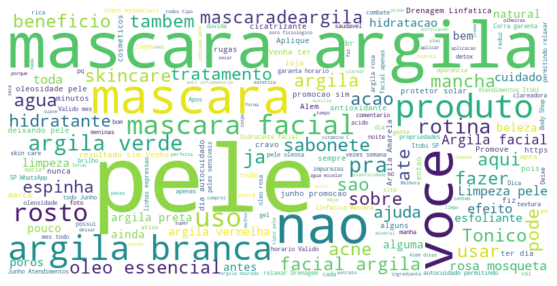

In [27]:
# Ler o arquivo de texto
with open('merged_fb.txt', 'r', encoding='utf-8') as file:
    texto = file.read()

# Tokenizar o texto em palavras
tokens = word_tokenize(texto, language='portuguese')

# Carregar as stopwords em português
stop_words = set(stopwords.words('portuguese'))

# Remover as stopwords do texto
tokens_sem_stopwords = [word for word in tokens if word.lower() not in stop_words]

# Unir os tokens sem stopwords novamente em um único texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)

# Criar a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_sem_stopwords)

# Exibir a nuvem de palavras usando matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Abaixo temos uma nova nuvem de palavras feita com os dados tratados, sem stopwords, ou palavras não relevantes ao nosso público.
Aqui podemos ver melhor onde desejamos procurar nosso público, as palavras possuem maior destaque e são mais fáceis de identificar, podemos visualizar palavras como: Pele, óleo, branca, acne, oleosa, mascara, limpeza, purificante, sabonete, cicatrizante entre outras.

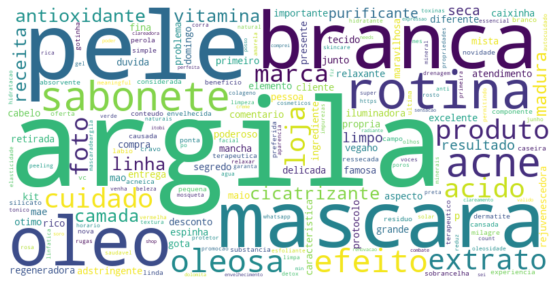

In [28]:
# Ler o arquivo de texto
with open('pyspark/fb_merged.csv', 'r', encoding='utf-8') as file:
    texto = file.read()

# Tokenizar o texto em palavras
tokens = word_tokenize(texto, language='portuguese')

# Carregar as stopwords em português
stop_words = set(stopwords.words('portuguese'))

# Remover as stopwords do texto
tokens_sem_stopwords = [word for word in tokens if word.lower() not in stop_words]

# Unir os tokens sem stopwords novamente em um único texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)

# Criar a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_sem_stopwords)

# Exibir a nuvem de palavras usando matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Essa análise inicial também foi feita para a junção dos nossos sites.
Nesse gráfico podemos visualizar as melhores palavras encontradas nos sites escolhidos.
Ex: Pele, argila, couro cabeludo, máscara argila, tratamento, argila branca, argila rosa, rosto, cabelo, natural, oleosidade, limpeza, benefícios e etc.
Podemos ver que as palavras são bem similares às encontradas na análise do facebook.

Aqui uma nuvem de palavras para a junção de todos os 20 sites.

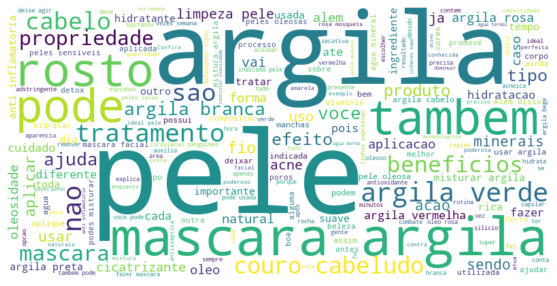

In [29]:
# Ler o arquivo de texto
with open('sites/merged_sites.txt', 'r', encoding='utf-8') as file:
    texto = file.read()

# Tokenizar o texto em palavras
tokens = word_tokenize(texto, language='portuguese')

# Carregar as stopwords em português
stop_words = set(stopwords.words('portuguese'))

# Remover as stopwords do texto
tokens_sem_stopwords = [word for word in tokens if word.lower() not in stop_words]

# Unir os tokens sem stopwords novamente em um único texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)

# Criar a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_sem_stopwords)

# Exibir a nuvem de palavras usando matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Com os dados tratados também realizamos a análise dos nossos dados coletados dos sites.
Aqui visualizamos as palavras com maior destaque nos sites, argila, pele, máscara, oleosidade, cabelo, cicatrizante, água, oleosa, minerais, rica.
Podemos ver que a similaridades das palavras encontradas é grande, ou seja, estamos no caminho certo em busca de sites para anunciarmos nosso produto.

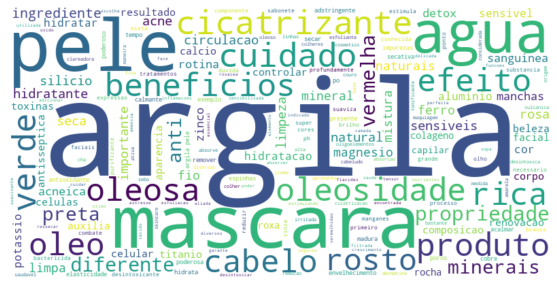

In [30]:
# Ler o arquivo de texto
with open('pyspark/combined_sites.csv', 'r', encoding='utf-8') as file:
    texto = file.read()

# Tokenizar o texto em palavras
tokens = word_tokenize(texto, language='portuguese')

# Carregar as stopwords em português
stop_words = set(stopwords.words('portuguese'))

# Remover as stopwords do texto
tokens_sem_stopwords = [word for word in tokens if word.lower() not in stop_words]

# Unir os tokens sem stopwords novamente em um único texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)

# Criar a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_sem_stopwords)

# Exibir a nuvem de palavras usando matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [31]:
texto = open('merged_fb.txt', 'r')
# Ler todo o conteúdo do arquivo como uma única string
conteudo = texto.read()
#print(conteudo)

# Ou ler o conteúdo do arquivo linha por linha
linhas = texto.readlines()
for linha in linhas:
    print(linha)

Texto base comentario facebook, para validar palavras

In [32]:
# Remover quebras de linha ("\n")
texto_sem_quebra_de_linha = re.sub(r"\n", "", conteudo)

# Remover caracteres especiais
texto = re.sub(r"[^\w\s]", "", texto_sem_quebra_de_linha)

In [33]:
termosExcluir=["de","para","um","dois",".","!","-", "que",",","'",",","\\n","\n", "e", "a", "o","Â", "2", "7", "3"]
stop = set(stopwords.words('portuguese'))
stopAll = stop.union(termosExcluir)
#print(stopAll)

Definindo as palavras de busca sobre o contexto do projeto.

In [34]:
#Palavras a serem buscados
palavras = ["máscara", "argila", "pele", "facial",
            "tratamento", "natural", "cuidados", "beleza", "limpeza", "hidratação", "acne", "rugas", "rejuvenescimento",
            "oleosidade", "esfoliação", "renovação", "detox", "estético", "benefícios", "revitalizante","nutritivo",
            "luminosidade", "antioxidante", "suavizante", "reequilibrante", "poro", "refrescante", "calmante",
            "restaurador", "etox", "minerais", "revigorante", "equilíbrio", "matificante", "clareador",
            "reafirmante", "radiância", "verde", "branca", "rosa", "vermelha", "amarela", "azul", "preta", "roxa"]

#palavras

In [35]:
# Buscando pelas palavras no texto
resultados = [termo for termo in palavras if termo in texto]

Palavras retornada já validada.

In [36]:
# Imprimindo os resultados encontrados
if resultados:
    print("Validando Palavras:")
    for resultado in resultados:
        print(resultado)
else:
    print("Nenhum palavra encontrado.")

Validando Palavras:
argila
pele
facial
tratamento
natural
cuidados
beleza
limpeza
acne
rugas
rejuvenescimento
oleosidade
detox
revitalizante
nutritivo
luminosidade
antioxidante
suavizante
poro
refrescante
calmante
etox
minerais
clareador
verde
branca
rosa
vermelha
amarela
azul
preta
roxa


Filtrando as palavras com ocorrencia > 1

In [37]:
# Criar um dicionário para armazenar as ocorrências
ocorrencias_encontradas = {}

# Iterar sobre os termos e contar suas ocorrências no texto
for termo in palavras:
    ocorrencias_encontradas[termo] = texto.count(termo)

# Filtrar os termos com contagem maior que zero
ocorrencias_filtradas = {termo: ocorrencia for termo, ocorrencia in ocorrencias_encontradas.items() if ocorrencia > 1}

# Imprimir as ocorrências encontradas
print("Ocorrências encontradas:")
for termo, ocorrencia in ocorrencias_filtradas.items():
    print(f"{termo}: {ocorrencia}")

# Armazenar as ocorrências filtradas em uma variável
ocorrencias_armazenadas = ocorrencias_filtradas

Ocorrências encontradas:
argila: 348
pele: 421
facial: 140
tratamento: 30
natural: 43
cuidados: 26
beleza: 38
limpeza: 43
acne: 61
rugas: 23
rejuvenescimento: 3
oleosidade: 62
detox: 19
revitalizante: 5
luminosidade: 4
antioxidante: 14
suavizante: 2
poro: 28
refrescante: 7
calmante: 7
etox: 28
minerais: 17
clareador: 21
verde: 50
branca: 56
rosa: 36
vermelha: 22
amarela: 13
preta: 26
roxa: 2


Contagem das palavras já validada

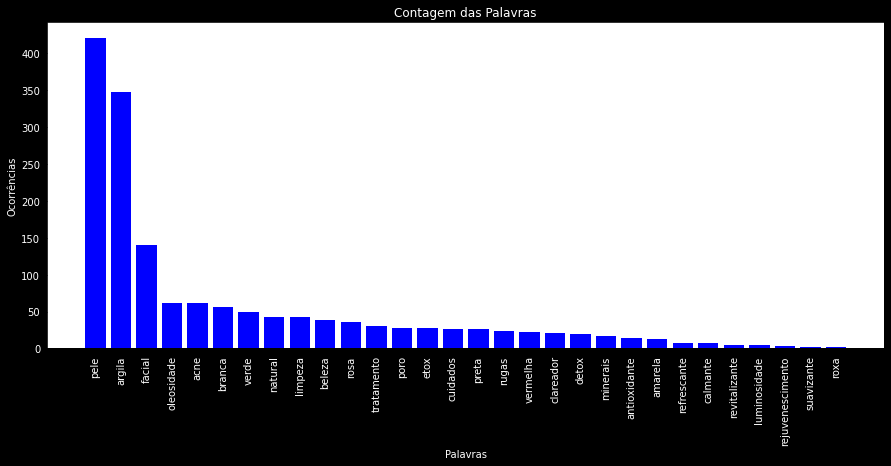

In [38]:
# Extrair rótulos e valores
rotulos = list(ocorrencias_filtradas.keys())
valores = list(ocorrencias_filtradas.values())

# Ordenar rótulos e valores em ordem decrescente com base nos valores
rotulos_ordenados, valores_ordenados = zip(*sorted(zip(rotulos, valores), key=lambda x: x[1], reverse=True))

# Configurar o tamanho da figura
plt.figure(figsize=(15, 6), facecolor='black')

# Plotar o gráfico de barras
plt.bar(rotulos_ordenados, valores_ordenados, color='blue')

# Configurar os rótulos e títulos com cor branca
plt.xlabel('Palavras', color='white')
plt.ylabel('Ocorrências', color='white')
plt.title('Contagem das Palavras', color='white')

# Configurar as cores das ticks
plt.xticks(rotation=90, color='white')
plt.yticks(color='white')

# Exibir o gráfico
plt.show()

Mostrando a importancia das palavras validada nos comentario das # facebook

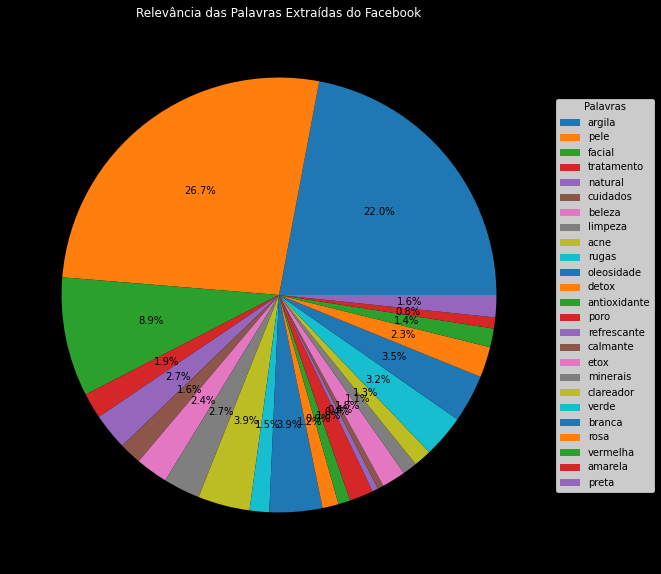

In [39]:
# Extrair rótulos e valores
rotulos = list(ocorrencias_filtradas.keys())
valores = list(ocorrencias_filtradas.values())

# Filtrar palavras com valores acima de 2%
rotulos_filtrados = []
valores_filtrados = []

for r, v in zip(rotulos, valores):
    if v > 5:
        rotulos_filtrados.append(r)
        valores_filtrados.append(v)

# Configurar o tamanho da figura
plt.figure(figsize=(25, 10), facecolor='black')

# Plotar o gráfico de pizza
grafico = plt.pie(valores_filtrados, labels=rotulos_filtrados, autopct='%1.1f%%')

# Adicionar legenda com as variáveis
plt.legend(grafico[0], rotulos_filtrados, title="Palavras", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Adicionar título
plt.title('Relevância das Palavras Extraídas do Facebook', color='white')

# Configurar cores das fatias
cores = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'gray']
plt.gca().set_prop_cycle('color', cores)

# Exibir o gráfico
plt.show()

Ordenando a importancias das top 10 palavras com base nas ocorrências, que se destaca em relação as demais

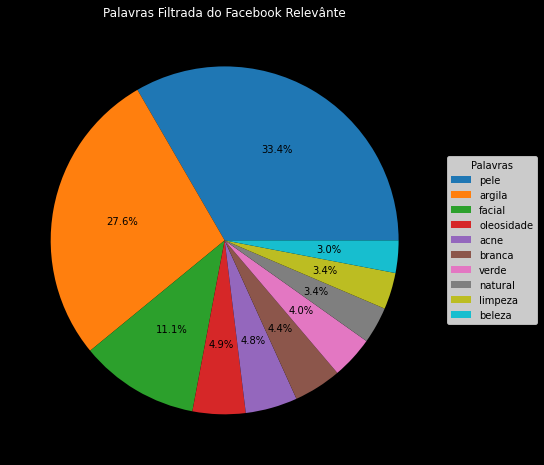

In [40]:
# Ordenar as palavras com base nas ocorrências filtradas
palavras_ordenadas = sorted(ocorrencias_filtradas, key=ocorrencias_filtradas.get, reverse=True)[:10]

# Obter os valores correspondentes às palavras ordenadas
valores_ordenados = [ocorrencias_filtradas[palavra] for palavra in palavras_ordenadas]

# Configurar o tamanho da figura
plt.figure(figsize=(15, 8), facecolor='black')

# Plotar o gráfico de pizza
grafico = plt.pie(valores_ordenados, labels=palavras_ordenadas, autopct='%1.1f%%')

# Adicionar legenda com as variáveis
plt.legend(grafico[0], palavras_ordenadas, title="Palavras", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Adicionar título
plt.title('Palavras Filtrada do Facebook Relevânte', color='white')

# Configurar cores das fatias
cores = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'gray']
plt.gca().set_prop_cycle('color', cores)

# Exibir o gráfico
plt.show()

### Análise dados do facebook

Limpando o conjunto de dados facebook, removendo parênteses, aspas e vírgulas

In [41]:
def limpar_texto_fb(texto):
    # Remove parênteses
    texto = texto.replace("(", "").replace(")", "")

    # Remove aspas
    texto = texto.replace('"', "").replace("'", "")

    # Remove vírgulas
    texto = texto.replace(",", "")

    return texto

# Carregando o dataset para efetua a limpeza
df = pd.read_csv("pyspark/fb_ngrams.csv")

# Aplique a função de limpeza para as colunas desejadas
colunas_limpar = ["Bigrama"]

for coluna in colunas_limpar:
    df[coluna] = df[coluna].apply(limpar_texto_fb)

# Salve o dataset limpo em um novo arquivo
df.to_csv("termos_facebook.csv", index=False)

In [42]:
# Carregue seu dataset termos do facebook
dataset = pd.read_csv("termos_facebook.csv")
#dataset

In [43]:
# Filtrar os termos com contagem acima de 10
termos_relevantes = dataset[dataset["Contagem"] > 10]

# Ordenar em ordem decrescente de contagem
termos_relevantes = termos_relevantes.sort_values(by="Contagem", ascending=False)

# Obter os top 20 termos relevantes
top_20_termos = termos_relevantes.head(20)

# Exibir o resultado
#print(top_20_termos)

Filtrando os termos com contagem acima de 10 repetições

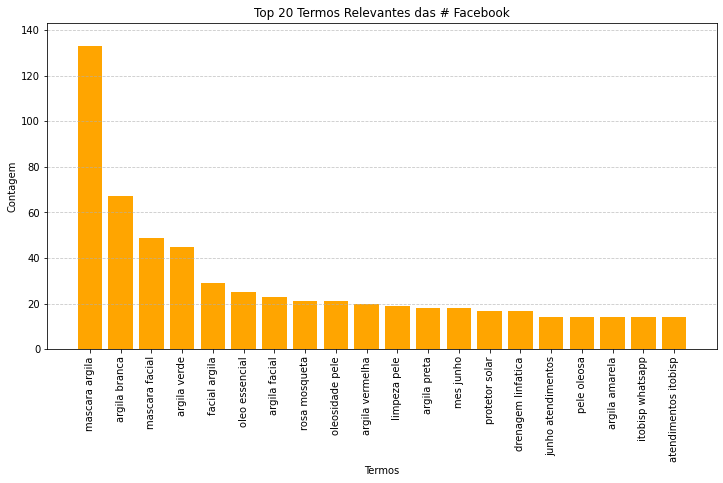

In [44]:
# Criar o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(top_20_termos["Bigrama"], top_20_termos["Contagem"], color="orange")

# Configurar o estilo do gráfico
plt.title("Top 20 Termos Relevantes das # Facebook")
plt.xlabel("Termos")
plt.ylabel("Contagem")
plt.xticks(rotation=90)
plt.ylim(0, top_20_termos["Contagem"].max() + 10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.gca().set_facecolor("white")

# Exibir o gráfico
plt.show()

Análise intuitiva das informações. Essas visualizações podem ser úteis para identificar padrões, tendências ou discrepâncias nos valores do termos

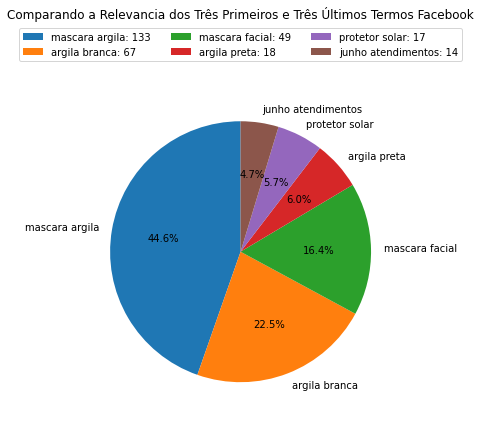

In [45]:
# Selecionar os três primeiros e a função (buscar_ultimos_valores_diferentes) busca o três últimos valores destinto do dataset
primeiros_valores = top_20_termos.head(3)

def buscar_ultimos_valores_diferentes(dataframe, coluna_contagem, coluna_valor, quantidade=3):
    ultimos_valores = dataframe.drop_duplicates(subset=coluna_valor, keep="last")
    ultimos_valores = ultimos_valores.sort_values(by=coluna_contagem, ascending=False)
    ultimos_valores = ultimos_valores[~ultimos_valores.duplicated(subset=coluna_contagem)]
    ultimos_valores = ultimos_valores.tail(quantidade)
    return ultimos_valores[[coluna_valor, coluna_contagem]]

ultimos_valores = buscar_ultimos_valores_diferentes(top_20_termos, "Contagem", "Bigrama", quantidade=3)

# Concatenar os valores para criar uma única visualização
valores_comparacao = pd.concat([primeiros_valores, ultimos_valores])

# Criar o gráfico de pizza
plt.figure(figsize=(8, 6))
plt.pie(valores_comparacao["Contagem"], labels=valores_comparacao["Bigrama"], autopct='%1.1f%%', startangle=90)

# Adicionar uma legenda com os valores das variáveis na parte superior
legend_labels = [f"{bigrama}: {contagem}" for bigrama, contagem in zip(valores_comparacao["Bigrama"], valores_comparacao["Contagem"])]
plt.legend(legend_labels, loc="upper center", bbox_to_anchor=(0.5, 1.20), ncol=3)

# Configurar o título do gráfico na parte inferior
plt.title("Comparando a Relevancia dos Três Primeiros e Três Últimos Termos Facebook", pad=70)

# Exibir o gráfico
plt.show()

**Análise de Termos Relevantes da comunidades Do Facebook**

Nesta tarefa, realizamos uma análise de termos relevantes com base em um conjunto de dados fornecidos. O objetivo era filtrar os termos relacionados a "máscara facial" e "argila" e calcular a contagem desses termos.

Passo 1: Carregamento dos Dados Inicialmente, carregamos os dados em um DataFrame para facilitar a manipulação. Os dados fornecidos continham duas colunas: "Bigrama" e "Contagem". A coluna "Bigrama" continha os termos e a coluna "Contagem" continha o número de ocorrências de cada termo.

Passo 2: Filtragem dos Termos Relevantes Em seguida, aplicamos um filtro para selecionar apenas os termos com contagem acima de 20. Utilizamos o operador de comparação ">" para filtrar os termos relevantes com base na coluna "Contagem". Os termos filtrados foram armazenados em um novo DataFrame chamado "termos_relevantes".

Passo 3: Ordenação dos Termos Com os termos relevantes filtrados, realizamos uma ordenação em ordem decrescente de contagem. Dessa forma, os termos com maior contagem ficaram no topo da lista, facilitando a identificação dos mais relevantes.

**Conclusão**:

Com base na análise dos dados fornecidos, identificamos os termos mais relevantes relacionados a "máscara facial" e "argila". Os termos "mascara argila" e "mascara facial" demonstraram como contagens mais altas, indicando que são os termos mais mencionados no conjunto de dados. Além disso, os termos "argila branca", "argila verde" e "argila vermelha" também foram considerados relevantes devido às suas manifestações de contágio.


---



---


In [46]:
#Troque o caminho abaixo pelo local onde os arquivos se encontram
os.chdir("sites")

In [47]:
# Função para limpar o texto
def limpar_texto(arquivo):
    # Abrir o arquivo de texto
    with open(arquivo, 'r', encoding="utf-8") as file:
        texto = file.read()

    # Limpeza das stop words usando o NLTK
    palavras = word_tokenize(texto)
    stopwords_pt = set(stopwords.words('portuguese'))
    palavras_sem_stopwords = [palavra for palavra in palavras if palavra.lower() not in stopwords_pt]

    # Limpeza de caracteres especiais
    padrao = r"[^\w\s]"
    texto_sem_caracteres = re.sub(padrao, "", " ".join(palavras_sem_stopwords))

    # Separação das palavras
    palavras_separadas = texto_sem_caracteres.split()

    # Criação do DataFrame
    df = pd.DataFrame({'Palavras': palavras_separadas})

    return df

In [48]:
# Lista com os nomes dos arquivos a processar
nomes_arquivos = ['site1_content.txt', 'site2_content.txt', 'site3_content.txt', 'site4_content.txt', 'site5_content.txt', 'site6_content.txt', 'site7_content.txt', 'site8_content.txt', 'site9_content.txt', 'site10_content.txt', 
                  'site11_content.txt', 'site12_content.txt', 'site13_content.txt', 'site14_content.txt', 'site15_content.txt', 'site16_content.txt', 'site17_content.txt', 'site18_content.txt', 'site19_content.txt', 'site20_content.txt']

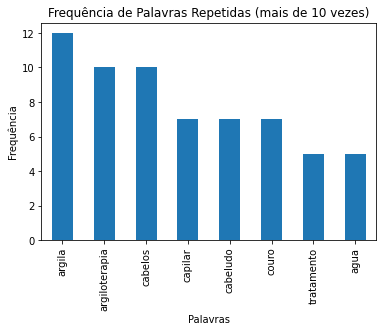

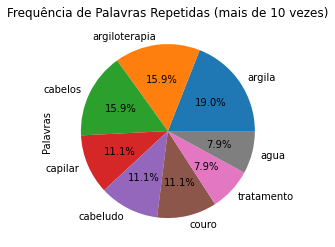

Palavras presentes no gráfico:
Index(['argila'], dtype='object')
--------------------


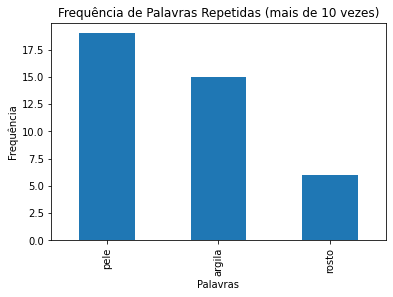

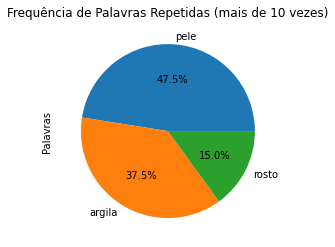

Palavras presentes no gráfico:
Index(['pele', 'argila'], dtype='object')
--------------------


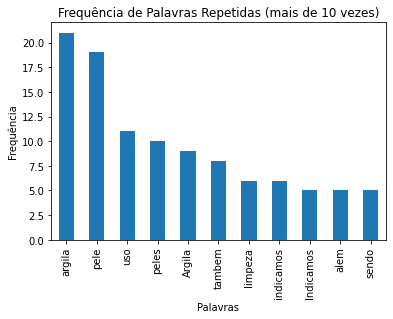

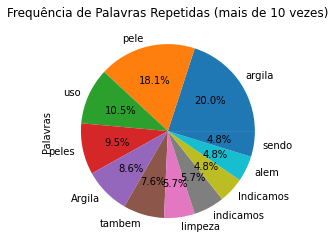

Palavras presentes no gráfico:
Index(['argila', 'pele'], dtype='object')
--------------------


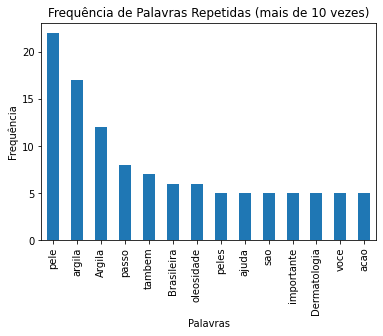

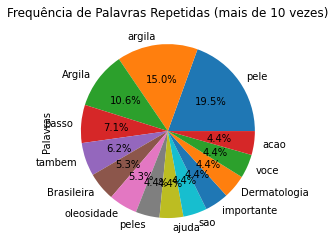

Palavras presentes no gráfico:
Index(['pele', 'argila'], dtype='object')
--------------------


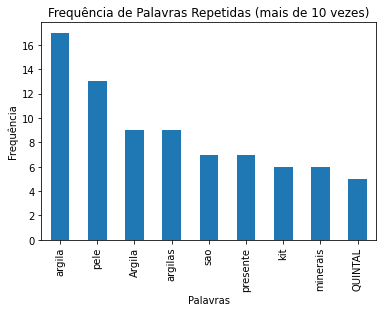

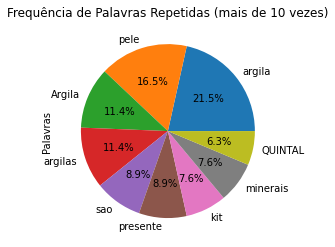

Palavras presentes no gráfico:
Index(['argila', 'pele'], dtype='object')
--------------------


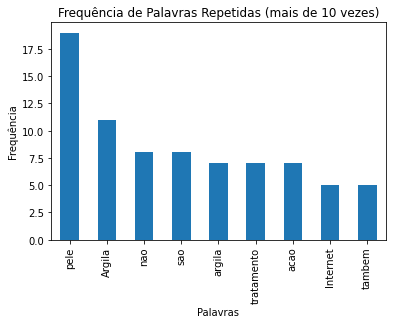

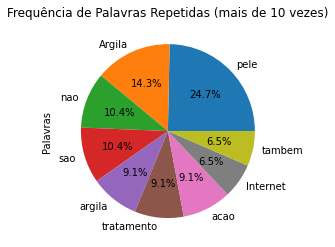

Palavras presentes no gráfico:
Index(['pele', 'argila'], dtype='object')
--------------------


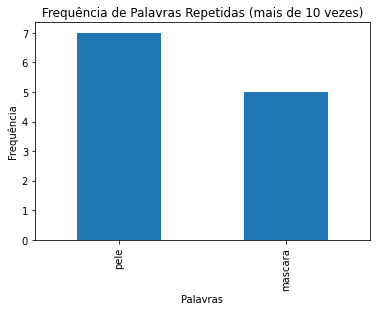

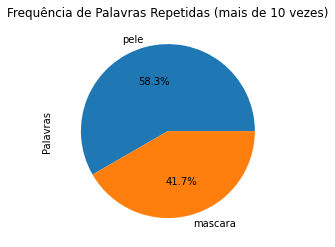

Palavras presentes no gráfico:
Index(['pele'], dtype='object')
--------------------


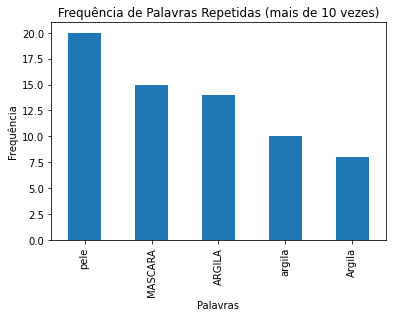

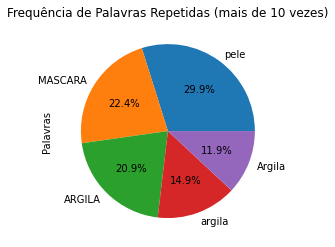

Palavras presentes no gráfico:
Index(['pele', 'argila'], dtype='object')
--------------------


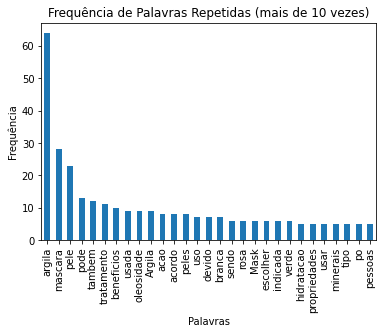

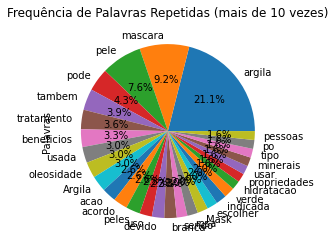

Palavras presentes no gráfico:
Index(['argila', 'pele'], dtype='object')
--------------------


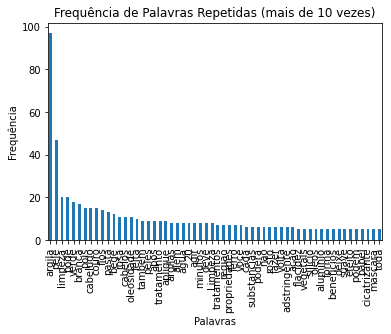

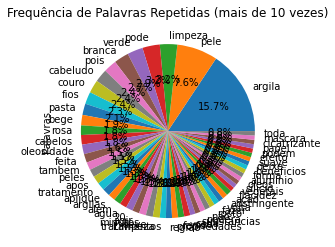

Palavras presentes no gráfico:
Index(['argila', 'pele'], dtype='object')
--------------------


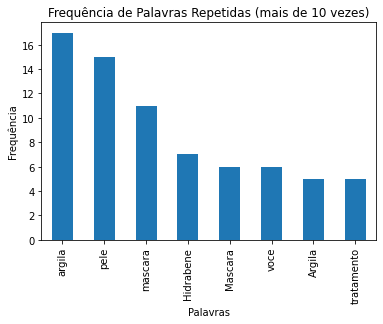

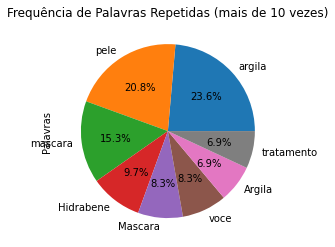

Palavras presentes no gráfico:
Index(['argila', 'pele'], dtype='object')
--------------------


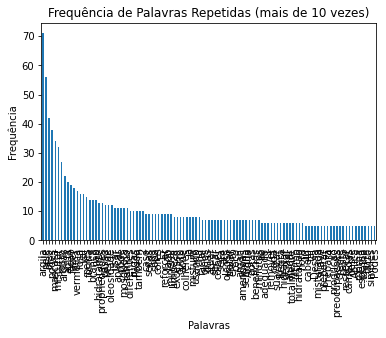

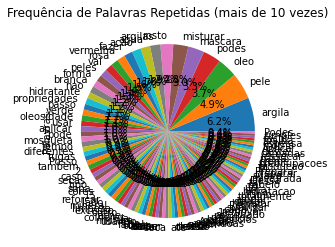

Palavras presentes no gráfico:
Index(['argila', 'pele', 'facial'], dtype='object')
--------------------


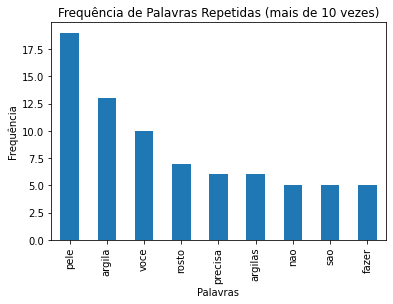

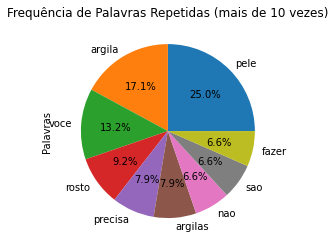

Palavras presentes no gráfico:
Index(['pele', 'argila'], dtype='object')
--------------------


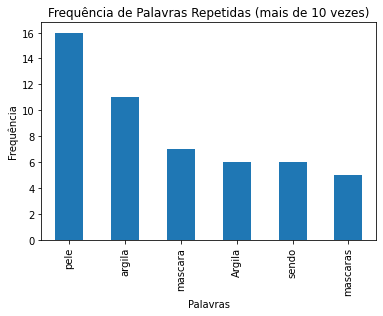

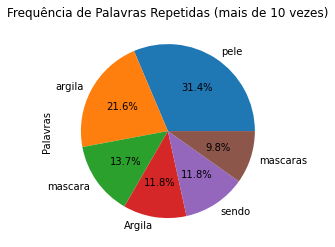

Palavras presentes no gráfico:
Index(['pele', 'argila'], dtype='object')
--------------------


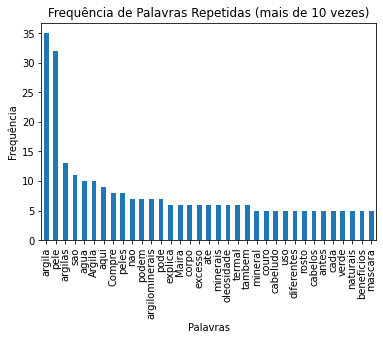

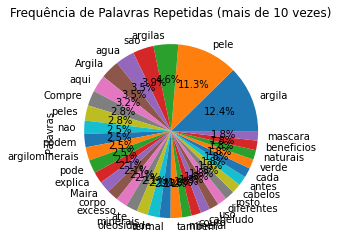

Palavras presentes no gráfico:
Index(['argila', 'pele'], dtype='object')
--------------------


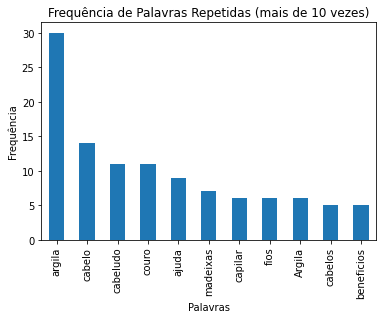

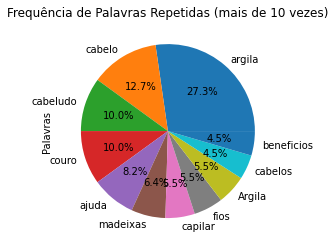

Palavras presentes no gráfico:
Index(['argila'], dtype='object')
--------------------


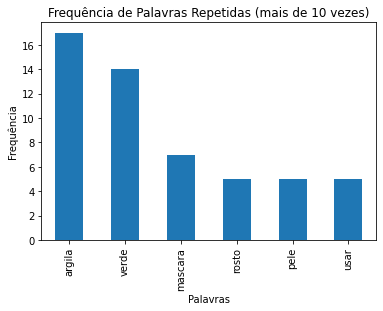

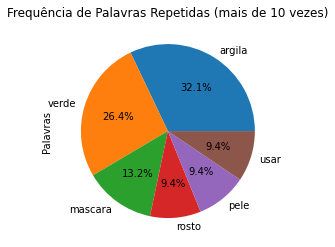

Palavras presentes no gráfico:
Index(['argila', 'pele'], dtype='object')
--------------------


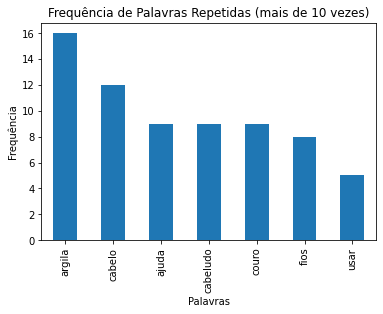

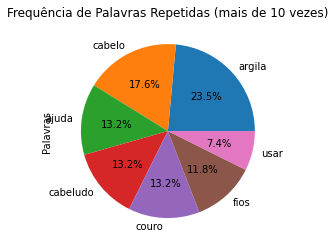

Palavras presentes no gráfico:
Index(['argila'], dtype='object')
--------------------


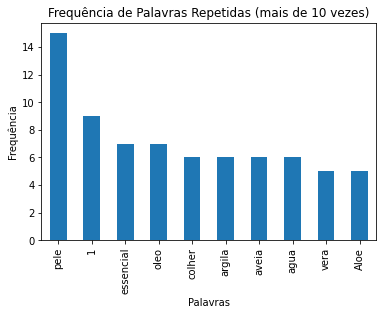

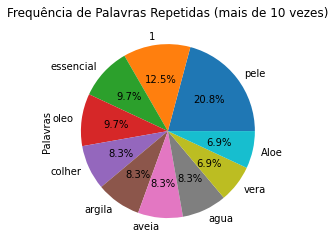

Palavras presentes no gráfico:
Index(['pele', 'argila'], dtype='object')
--------------------


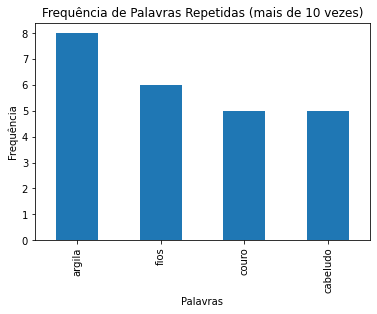

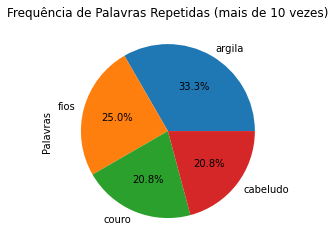

Palavras presentes no gráfico:
Index(['argila'], dtype='object')
--------------------


In [49]:
# Processar cada arquivo individualmente
for nome_arquivo in nomes_arquivos:
    # Chama a função para limpar o texto e criar o DataFrame
    dataframe = limpar_texto(nome_arquivo)
    contagem = dataframe['Palavras'].value_counts()

    # Filtrar apenas as palavras que se repetem mais de 10 vezes
    contagem_filtrada = contagem[contagem > 4]

    # Criar o gráfico de barras
    contagem_filtrada.plot(kind='bar')

    # Configurar os rótulos e título do gráfico
    plt.xlabel('Palavras')
    plt.ylabel('Frequência')
    plt.title('Frequência de Palavras Repetidas (mais de 10 vezes)')

    # Exibir o gráfico
    plt.show()

    # Criar o gráfico de pizza
    contagem_filtrada.plot(kind='pie', autopct='%1.1f%%')

    # Configurar o título do gráfico
    plt.title('Frequência de Palavras Repetidas (mais de 10 vezes)')

    # Exibir o gráfico
    plt.show()

    # Lista de palavras a verificar
    lista_palavras = ["máscara", "argila", "pele", "facial", ...]  # Adicione as palavras que você deseja verificar

    # Verificar se as palavras da lista estão presentes no gráfico
    palavras_presentes = contagem_filtrada.index.isin(lista_palavras)

    # Exibir as palavras da lista que estão presentes no gráfico
    print("Palavras presentes no gráfico:")
    print(contagem_filtrada.index[palavras_presentes])
    print("--------------------")

In [50]:
os.chdir("..")

### Termos Relevantes dos Principais Sites

In [51]:
def limpar_texto_site(text):
    # Remove parênteses
    text = text.replace("(", "").replace(")", "")

    # Remove aspas
    text = text.replace('"', "").replace("'", "")

    # Remove vírgulas
    text = text.replace(",", "")

    return text

# Carregando o dataset para efetua a limpeza
df = pd.read_csv("pyspark/sites_ngrams.csv")

# Aplique a função de limpeza para as colunas desejadas
colunas_limpar = ["Bigrama"]

for coluna in colunas_limpar:
    df[coluna] = df[coluna].apply(limpar_texto_site)

# Salve o dataset limpo em um novo arquivo
df.to_csv("termos_sites.csv", index=False)

In [52]:
# Carregando o dataset termos do Sites
data = pd.read_csv("termos_sites.csv")
#data

In [53]:
# Renomear as colunas
data.rename(columns={"Bigrama": "Termo", "Contagem": "Valor"}, inplace=True)
# Filtrar os termos com contagem acima de 10
data = data[data["Valor"] > 10]
#data

In [54]:
# Ordenar em ordem decrescente de contagem
termos_site = data.sort_values(by="Valor", ascending=False)

# Obter os top 30 termos relevantes
top_30 = termos_site.head(30)

# Exibir o resultado
#print(top_30)

Obtendo os top 30 termos relevantes dos principais sites com valores acima de 10 repetições.

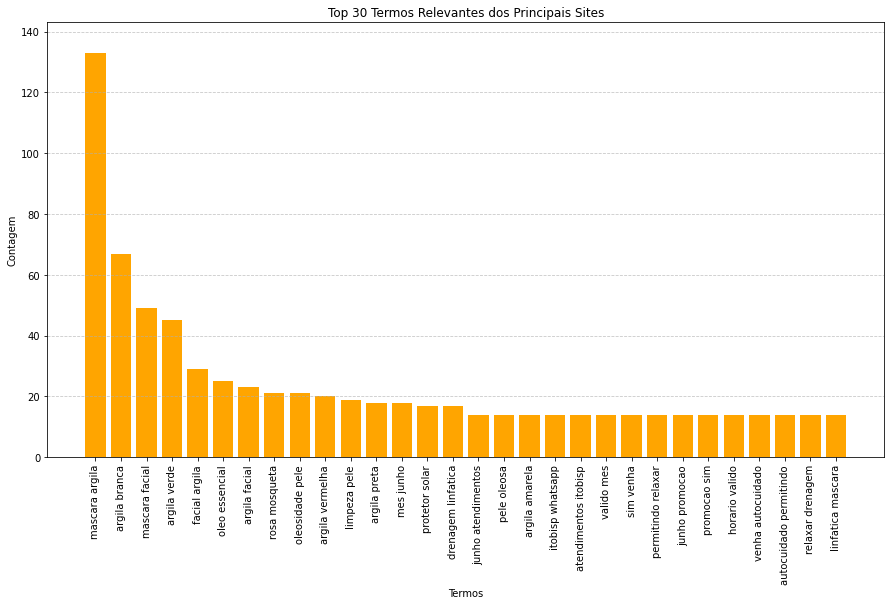

In [55]:
# Criar o gráfico de barras
plt.figure(figsize=(15, 8))
plt.bar(top_30["Termo"], top_30["Valor"], color="orange")

# Configurar o estilo do gráfico
plt.title("Top 30 Termos Relevantes dos Principais Sites")
plt.xlabel("Termos")
plt.ylabel("Contagem")
plt.xticks(rotation=90)
plt.ylim(0, top_30["Valor"].max() + 10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.gca().set_facecolor("white")

# Exibir o gráfico
plt.show()

Identificando padrões, tendências ou discrepâncias nos valores do dados

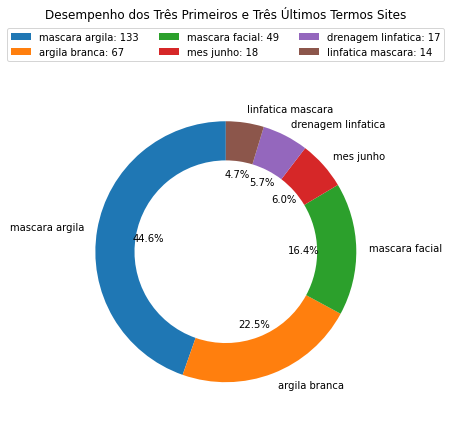

In [56]:
# Selecionar os três primeiros e três últimos valores do dataset
primeiros_valor = top_30.head(3)

def buscar_ultimos_valores_distintos(dataframe, coluna_contagem, coluna_valor, quantidade=3):
    ultimas_linhas = dataframe.drop_duplicates(subset=coluna_contagem, keep="last")
    ultimas_linhas = ultimas_linhas.tail(quantidade)
    ultimos_valores = ultimas_linhas[[coluna_valor, coluna_contagem]]
    return ultimos_valores

ultimos_valores_distintos = buscar_ultimos_valores_distintos(top_30, "Valor", "Termo", quantidade=3)

# Concatenar os valores para criar uma única visualização
comparacao = pd.concat([primeiros_valor, ultimos_valores_distintos])

# Criar o gráfico de rosca
plt.figure(figsize=(8, 6))
plt.pie(comparacao["Valor"], labels=comparacao["Termo"], autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))

# Adicionar uma legenda com os valores das variáveis na parte superior
labels = [f"{termo}: {valor}" for termo, valor in zip(comparacao["Termo"], comparacao["Valor"])]
plt.legend(labels, loc="upper center", bbox_to_anchor=(0.5, 1.20), ncol=3)

# Configurar o título do gráfico
plt.title("Desempenho dos Três Primeiros e Três Últimos Termos Sites", pad=70)

# Exibir o gráfico
plt.show()

**Relatório da Contagem dos Termos Relevantes dos Principais Sites:**

Nesta análise, foi realizado o levantamento da contagem dos Termos Relevantes dos Principais Sites. O objetivo era identificar os termos mais mencionados e sua frequência nos principais sites, limpeza do conjunto de dados, removendo parênteses, aspas e vírgulas.

Passo 1: Coleta dos Dados Foram coletados os dados dos principais sites e organizados em um DataFrame chamado df. O DataFrame possui duas colunas: "Termo" e "Valor". A coluna "Termo" contém os termos relevantes encontrados nos principais sites, e a coluna "Valor" registra a frequência de cada termo.

Passo 2: Análise dos Dados Realizamos uma análise dos dados para identificar os principais termos relevantes e sua contagem nos principais sites. A contagem dos termos fornece uma visão quantitativa de sua importância e popularidade.

Passo 3: Visualização dos Dados Para uma melhor compreensão dos resultados, criamos um gráfico de barras para representar visualmente a contagem dos termos relevantes. O gráfico de barras é uma forma eficaz de comparar a frequência dos termos e identificar os mais mencionados.

**Conclusão:**

Com base na análise da contagem dos Termos Relevantes dos Principais Sites, foram identificados os termos mais mencionados e sua frequência. Essas informações são úteis para compreender os assuntos mais discutidos nos principais sites e podem fornecer insights valiosos para análises posteriores.

**Recomendações:**

É recomendável continuar monitorando e atualizando a contagem dos termos relevantes em intervalos regulares, pois a popularidade dos termos pode variar ao longo do tempo. Essa análise pode fornecer informações valiosas para melhorar estratégias de SEO, identificar tendências e entender o interesse dos usuários nos principais sites.

## Analise das Palavras dos 20 Sites Contado com Spark

In [57]:
csv1 = pd.read_csv('pyspark/site1.csv')
# Renomear as colunas
csv1.rename(columns={"meaningful": "Palavra"}, inplace=True)
#csv1

Filtrando palavras com contagem acima de 2 repetições

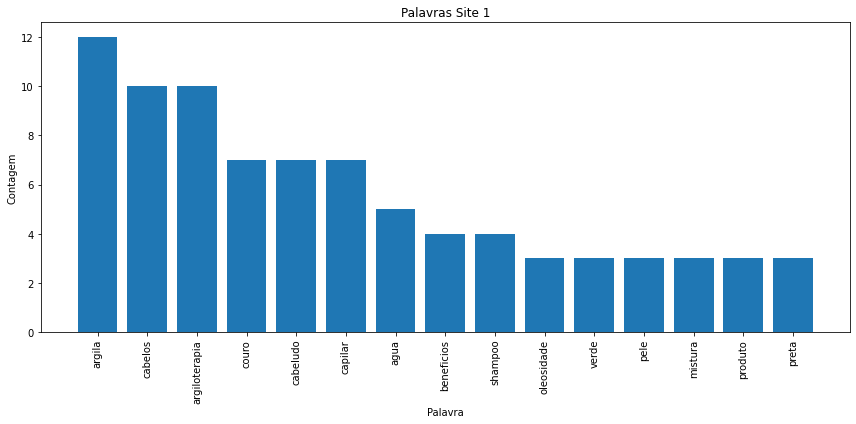

In [58]:
# Filtrando palavras com contagem acima de 2
palavras_filtrada_site1 = [palavra for palavra, count in zip(csv1['Palavra'], csv1['count']) if count > 2]
contagem_filtrada_site1 = [count for count in csv1['count'] if count > 2]

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(palavras_filtrada_site1, contagem_filtrada_site1)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Contagem')
plt.title('Palavras Site 1')
plt.tight_layout()
plt.show()

In [59]:
csv2 = pd.read_csv('pyspark/site2.csv')
# Renomear as colunas
csv2.rename(columns={"meaningful": "Palavra"}, inplace=True)
#csv2

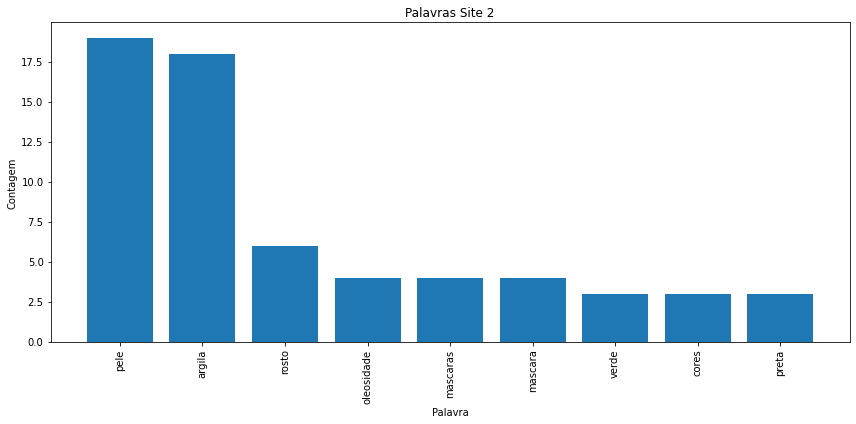

In [60]:
# Filtrando palavras com contagem acima de 2
palavras_filtrada_site2 = [palavras for palavras, count in zip(csv2['Palavra'], csv2['count']) if count > 2]
contagem_filtradas_site2 = [count for count in csv2['count'] if count > 2]

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(palavras_filtrada_site2, contagem_filtradas_site2)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Contagem')
plt.title('Palavras Site 2')
plt.tight_layout()
plt.show()

In [61]:
csv3 = pd.read_csv('pyspark/site3.csv')
# Renomear as colunas
csv3.rename(columns={"meaningful": "Palavra"}, inplace=True)
#csv3

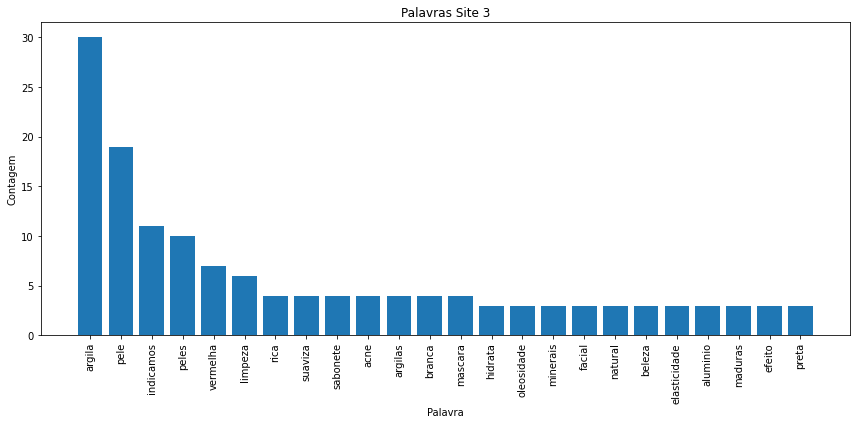

In [62]:
# Filtrando palavras com contagem acima de 2
palavras_filtrada_site3 = [palavras for palavras, count in zip(csv3['Palavra'], csv3['count']) if count > 2]
contagem_filtradas_site3 = [count for count in csv3['count'] if count > 2]

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(palavras_filtrada_site3, contagem_filtradas_site3)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Contagem')
plt.title('Palavras Site 3')
plt.tight_layout()
plt.show()

In [63]:
csv4 = pd.read_csv('pyspark/site4.csv')
# Renomear as colunas
csv4.rename(columns={"meaningful": "Palavra"}, inplace=True)
#csv4

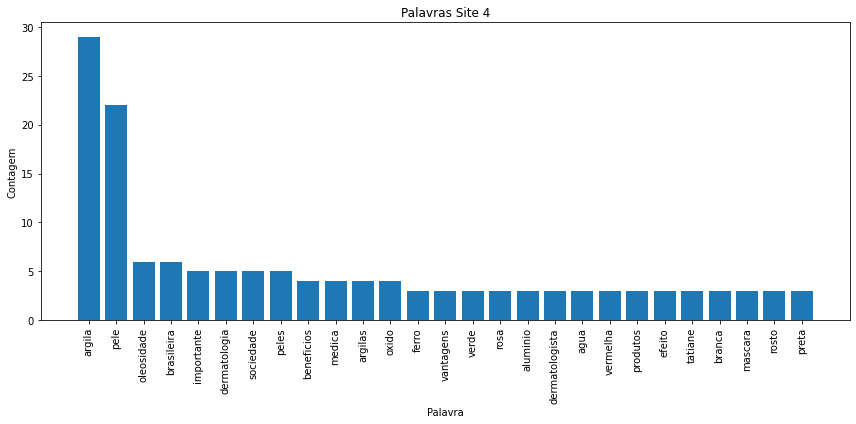

In [64]:
# Filtrando palavras com contagem acima de 2
palavras_filtrada_site4 = [palavras for palavras, count in zip(csv4['Palavra'], csv4['count']) if count > 2]
contagem_filtradas_site4 = [count for count in csv4['count'] if count > 2]

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(palavras_filtrada_site4, contagem_filtradas_site4)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Contagem')
plt.title('Palavras Site 4')
plt.tight_layout()
plt.show()

In [65]:
csv5 = pd.read_csv('pyspark/site5.csv')
# Renomear as colunas
csv5.rename(columns={"meaningful": "Palavra"}, inplace=True)
#csv5

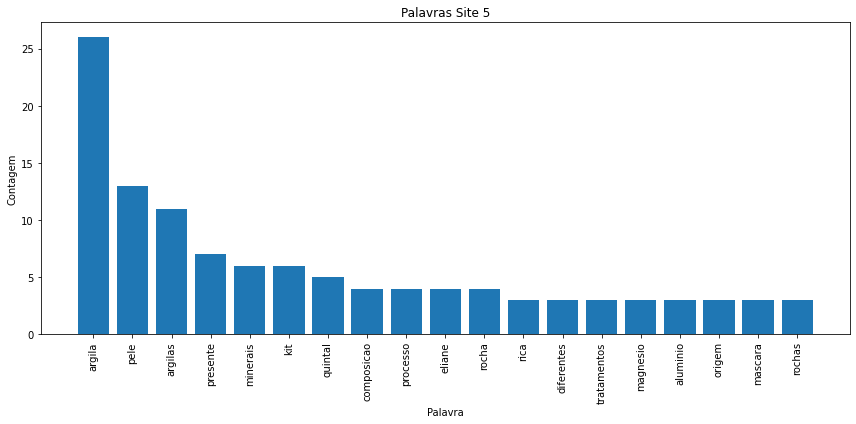

In [66]:
# Filtrando palavras com contagem acima de 2
palavras_filtrada_site5 = [palavras for palavras, count in zip(csv5['Palavra'], csv5['count']) if count > 2]
contagem_filtradas_site5 = [count for count in csv5['count'] if count > 2]

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(palavras_filtrada_site5, contagem_filtradas_site5)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Contagem')
plt.title('Palavras Site 5')
plt.tight_layout()
plt.show()

In [67]:
csv6 = pd.read_csv('pyspark/site6.csv')
# Renomear as colunas
csv6.rename(columns={"meaningful": "Palavra"}, inplace=True)
#csv6

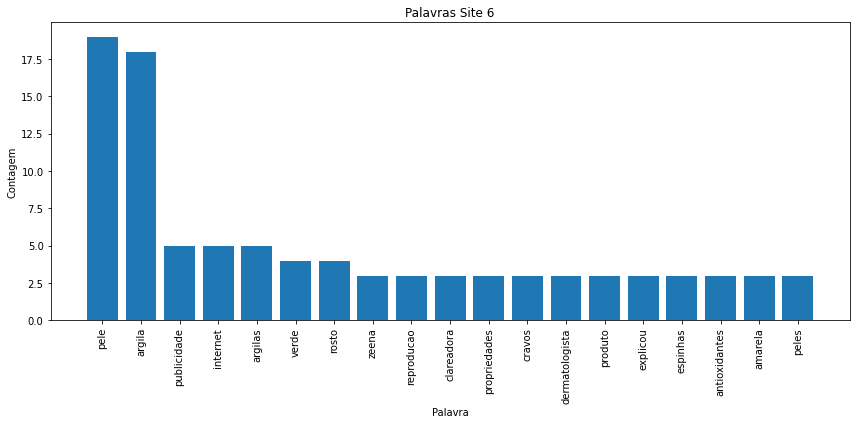

In [68]:
# Filtrando palavras com contagem acima de 2
palavras_filtrada_site6 = [palavras for palavras, count in zip(csv6['Palavra'], csv6['count']) if count > 2]
contagem_filtradas_site6 = [count for count in csv6['count'] if count > 2]

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(palavras_filtrada_site6, contagem_filtradas_site6)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Contagem')
plt.title('Palavras Site 6')
plt.tight_layout()
plt.show()

In [69]:
csv7 = pd.read_csv('pyspark/site7.csv')
# Renomear as colunas
csv7.rename(columns={"meaningful": "Palavra"}, inplace=True)
#csv7

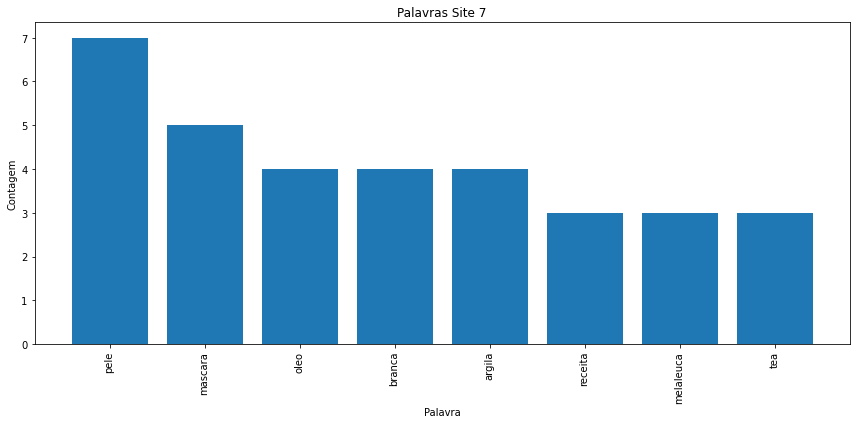

In [70]:
# Filtrando palavras com contagem acima de 2
palavras_filtrada_site7 = [palavras for palavras, count in zip(csv7['Palavra'], csv7['count']) if count > 2]
contagem_filtradas_site7 = [count for count in csv7['count'] if count > 2]

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(palavras_filtrada_site7, contagem_filtradas_site7)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Contagem')
plt.title('Palavras Site 7')
plt.tight_layout()
plt.show()

In [71]:
csv8 = pd.read_csv('pyspark/site8.csv')
# Renomear as colunas
csv8.rename(columns={"meaningful": "Palavra"}, inplace=True)
#csv8

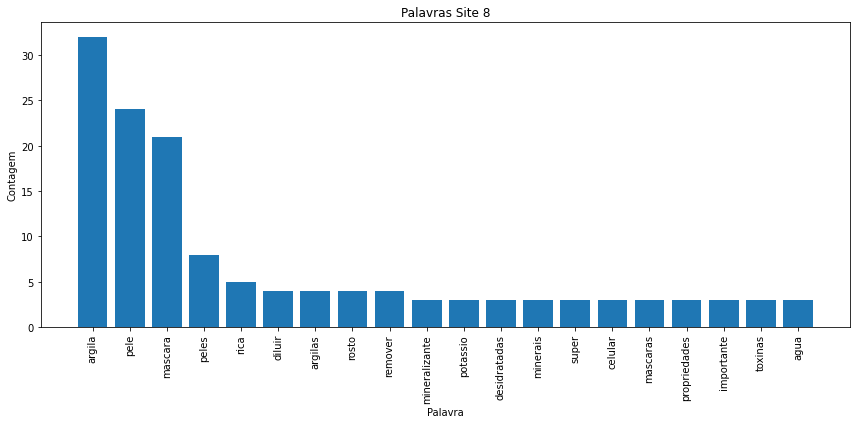

In [72]:
# Filtrando palavras com contagem acima de 2
palavras_filtrada_site8 = [palavras for palavras, count in zip(csv8['Palavra'], csv8['count']) if count > 2]
contagem_filtradas_site8 = [count for count in csv8['count'] if count > 2]

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(palavras_filtrada_site8, contagem_filtradas_site8)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Contagem')
plt.title('Palavras Site 8')
plt.tight_layout()
plt.show()

In [73]:
csv9 = pd.read_csv('pyspark/site9.csv')
# Renomear as colunas
csv9.rename(columns={"meaningful": "Palavra"}, inplace=True)
#csv9

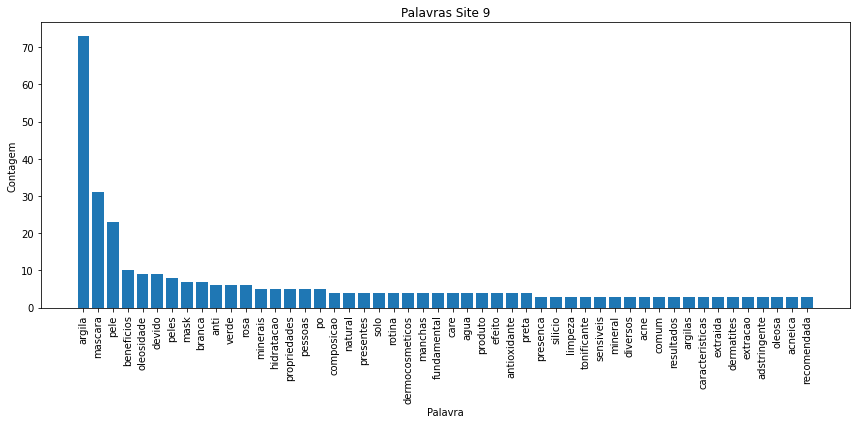

In [74]:
# Filtrando palavras com contagem acima de 2
palavras_filtrada_site9 = [palavras for palavras, count in zip(csv9['Palavra'], csv9['count']) if count > 2]
contagem_filtradas_site9 = [count for count in csv9['count'] if count > 2]

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(palavras_filtrada_site9, contagem_filtradas_site9)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Contagem')
plt.title('Palavras Site 9')
plt.tight_layout()
plt.show()

In [75]:
csv10 = pd.read_csv('pyspark/site10.csv')
# Renomear as colunas
csv10.rename(columns={"meaningful": "Palavra"}, inplace=True)
#csv10

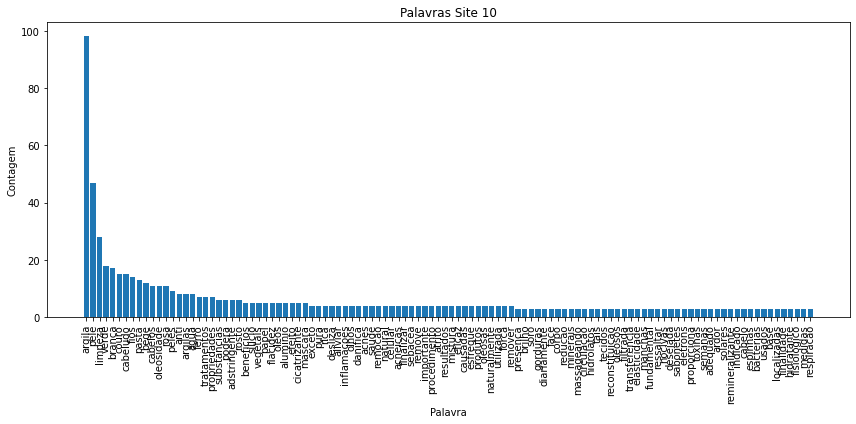

In [76]:
# Filtrando palavras com contagem acima de 2
palavras_filtrada_site10 = [palavras for palavras, count in zip(csv10['Palavra'], csv10['count']) if count > 2]
contagem_filtradas_site10 = [count for count in csv10['count'] if count > 2]

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(palavras_filtrada_site10, contagem_filtradas_site10)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Contagem')
plt.title('Palavras Site 10')
plt.tight_layout()
plt.show()

In [77]:
csv11 = pd.read_csv('pyspark/site11.csv')
# Renomear as colunas
csv11.rename(columns={"meaningful": "Palavra"}, inplace=True)
#csv11

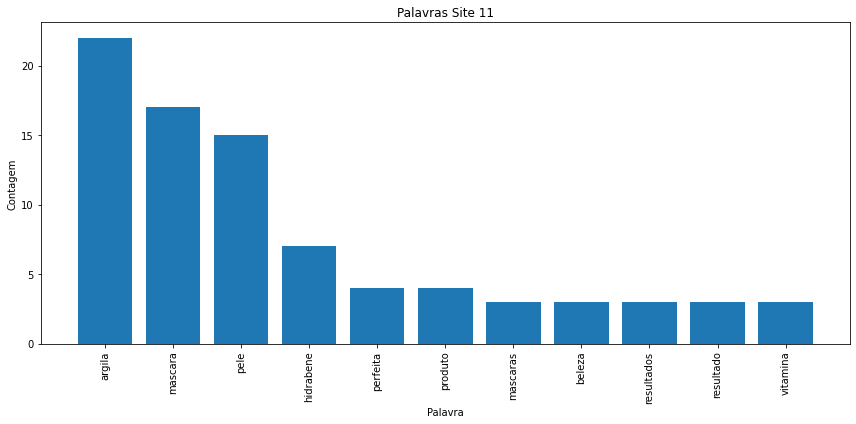

In [78]:
# Filtrando palavras com contagem acima de 2
palavras_filtrada_site11 = [palavras for palavras, count in zip(csv11['Palavra'], csv11['count']) if count > 2]
contagem_filtradas_site11 = [count for count in csv11['count'] if count > 2]

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(palavras_filtrada_site11, contagem_filtradas_site11)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Contagem')
plt.title('Palavras Site 11')
plt.tight_layout()
plt.show()

In [79]:
csv12 = pd.read_csv('pyspark/site12.csv')
# Renomear as colunas
csv12.rename(columns={"meaningful": "Palavra"}, inplace=True)
#csv12

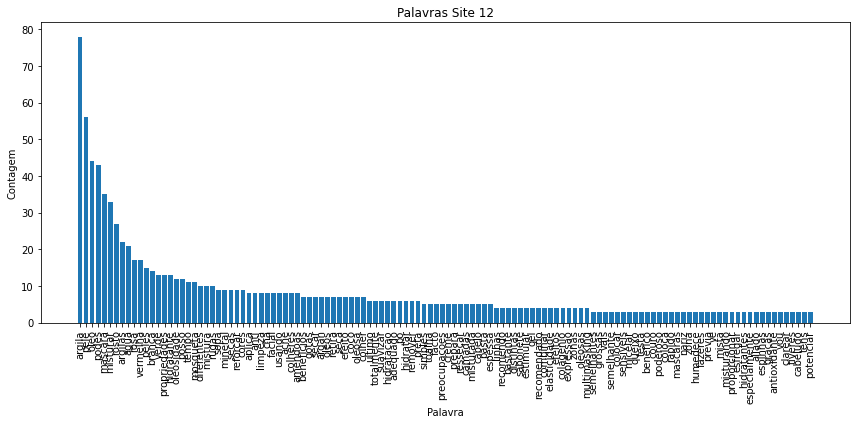

In [80]:
# Filtrando palavras com contagem acima de 2
palavras_filtrada_site12 = [palavras for palavras, count in zip(csv12['Palavra'], csv12['count']) if count > 2]
contagem_filtradas_site12 = [count for count in csv12['count'] if count > 2]

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(palavras_filtrada_site12, contagem_filtradas_site12)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Contagem')
plt.title('Palavras Site 12')
plt.tight_layout()
plt.show()

In [81]:
csv13 = pd.read_csv('pyspark/site13.csv')
# Renomear as colunas
csv13.rename(columns={"meaningful": "Palavra"}, inplace=True)
#csv13

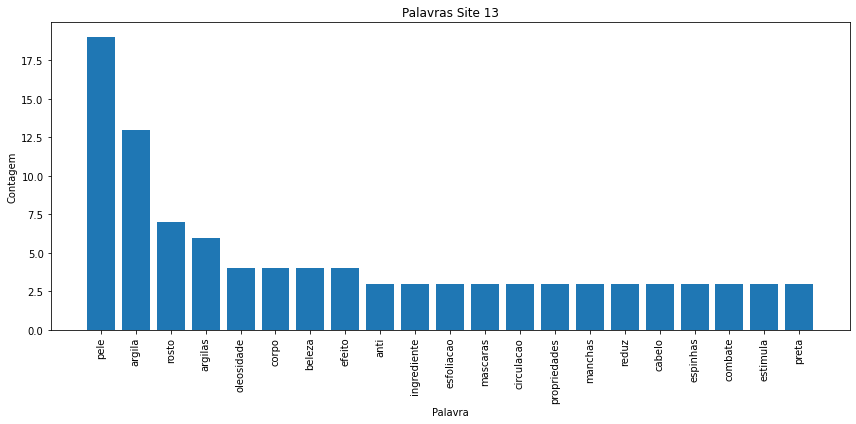

In [82]:
# Filtrando palavras com contagem acima de 2
palavras_filtrada_site13 = [palavras for palavras, count in zip(csv13['Palavra'], csv13['count']) if count > 2]
contagem_filtradas_site13 = [count for count in csv13['count'] if count > 2]

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(palavras_filtrada_site13, contagem_filtradas_site13)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Contagem')
plt.title('Palavras Site 13')
plt.tight_layout()
plt.show()

In [83]:
csv14 = pd.read_csv('pyspark/site14.csv')
# Renomear as colunas
csv14.rename(columns={"meaningful": "Palavra"}, inplace=True)
#csv14

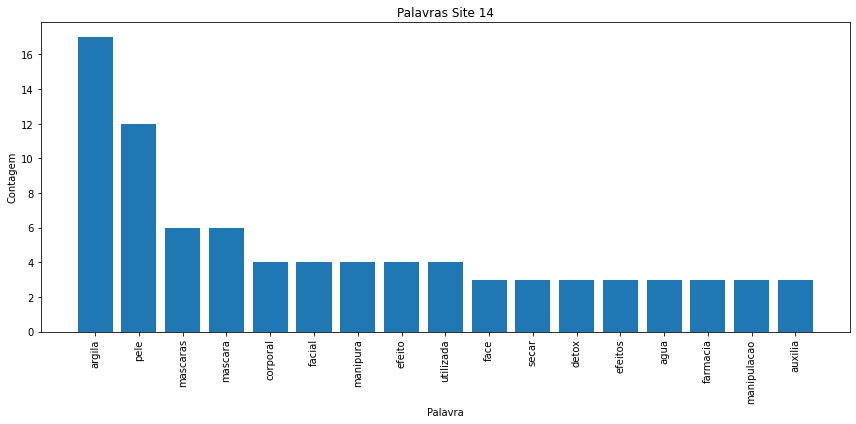

In [84]:
# Filtrando palavras com contagem acima de 2
palavras_filtrada_site14 = [palavras for palavras, count in zip(csv14['Palavra'], csv14['count']) if count > 2]
contagem_filtradas_site14 = [count for count in csv14['count'] if count > 2]

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(palavras_filtrada_site14, contagem_filtradas_site14)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Contagem')
plt.title('Palavras Site 14')
plt.tight_layout()
plt.show()

In [85]:
csv15 = pd.read_csv('pyspark/site15.csv')
# Renomear as colunas
csv15.rename(columns={"meaningful": "Palavra"}, inplace=True)
#csv15

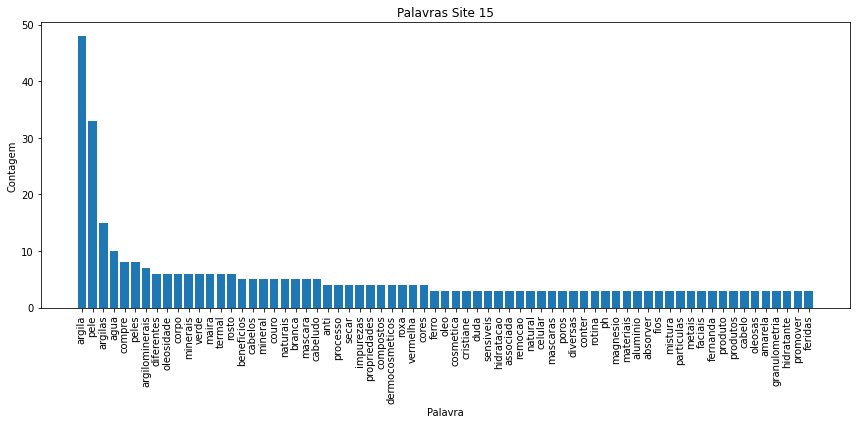

In [86]:
# Filtrando palavras com contagem acima de 2
palavras_filtrada_site15 = [palavras for palavras, count in zip(csv15['Palavra'], csv15['count']) if count > 2]
contagem_filtradas_site15 = [count for count in csv15['count'] if count > 2]

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(palavras_filtrada_site15, contagem_filtradas_site15)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Contagem')
plt.title('Palavras Site 15')
plt.tight_layout()
plt.show()

In [87]:
csv16 = pd.read_csv('pyspark/site16.csv')
# Renomear as colunas
csv16.rename(columns={"meaningful": "Palavra"}, inplace=True)
#csv16

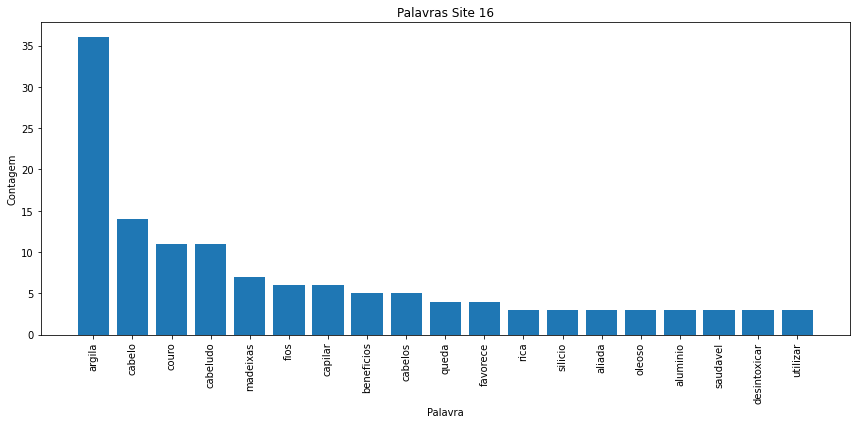

In [88]:
# Filtrando palavras com contagem acima de 2
palavras_filtrada_site16 = [palavras for palavras, count in zip(csv16['Palavra'], csv16['count']) if count > 2]
contagem_filtradas_site16 = [count for count in csv16['count'] if count > 2]

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(palavras_filtrada_site16, contagem_filtradas_site16)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Contagem')
plt.title('Palavras Site 16')
plt.tight_layout()
plt.show()

In [89]:
csv17 = pd.read_csv('pyspark/site17.csv')
# Renomear as colunas
csv17.rename(columns={"meaningful": "Palavra"}, inplace=True)
#csv17

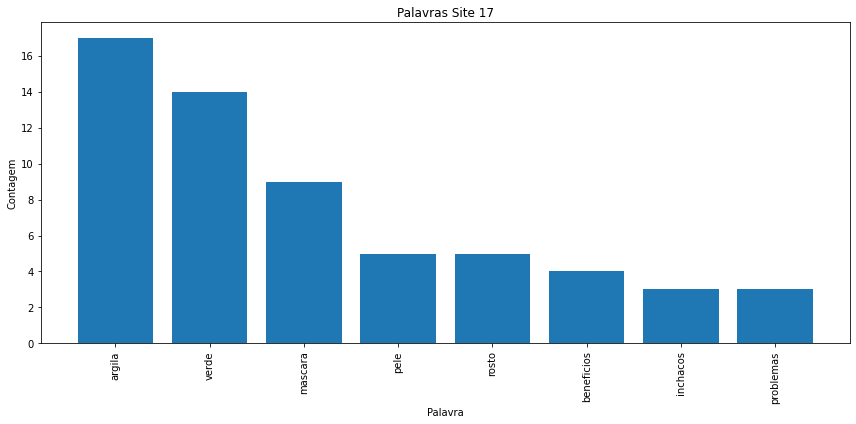

In [90]:
# Filtrando palavras com contagem acima de 2
palavras_filtrada_site17 = [palavras for palavras, count in zip(csv17['Palavra'], csv17['count']) if count > 2]
contagem_filtradas_site17 = [count for count in csv17['count'] if count > 2]

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(palavras_filtrada_site17, contagem_filtradas_site17)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Contagem')
plt.title('Palavras Site 17')
plt.tight_layout()
plt.show()

In [91]:
csv18 = pd.read_csv('pyspark/site18.csv')
# Renomear as colunas
csv18.rename(columns={"meaningful": "Palavra"}, inplace=True)
#csv18

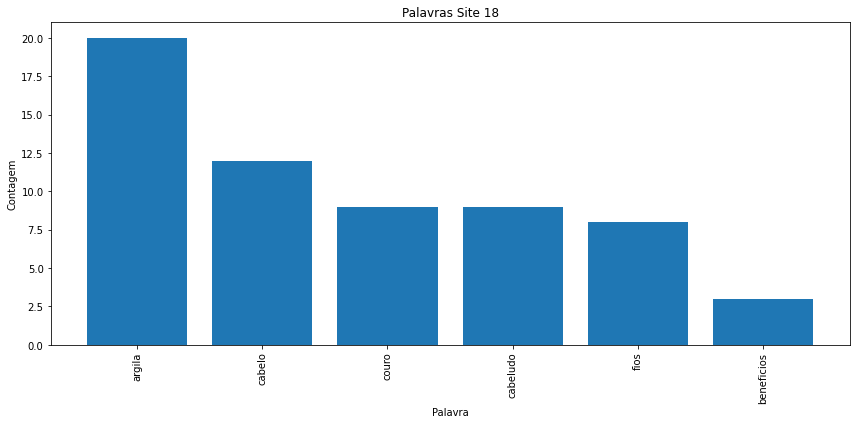

In [92]:
# Filtrando palavras com contagem acima de 2
palavras_filtrada_site18 = [palavras for palavras, count in zip(csv18['Palavra'], csv18['count']) if count > 2]
contagem_filtradas_site18 = [count for count in csv18['count'] if count > 2]

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(palavras_filtrada_site18, contagem_filtradas_site18)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Contagem')
plt.title('Palavras Site 18')
plt.tight_layout()
plt.show()

In [93]:
csv19 = pd.read_csv('pyspark/site19.csv')
# Renomear as colunas
csv19.rename(columns={"meaningful": "Palavra"}, inplace=True)
#csv19

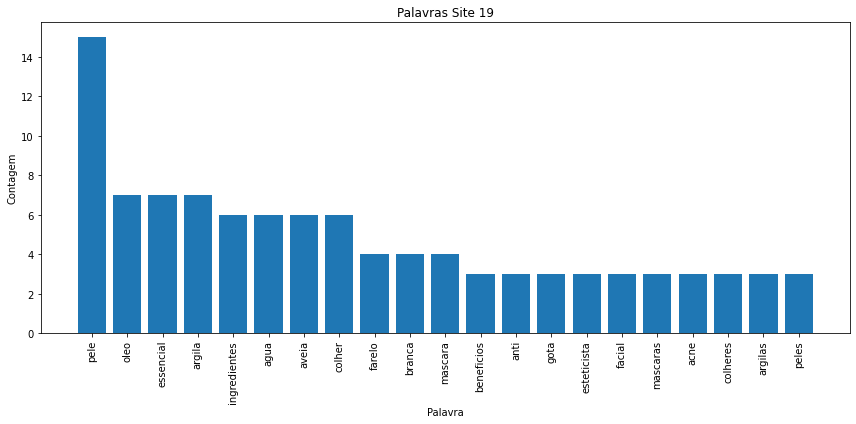

In [94]:
# Filtrando palavras com contagem acima de 2
palavras_filtrada_site19 = [palavras for palavras, count in zip(csv19['Palavra'], csv19['count']) if count > 2]
contagem_filtradas_site19 = [count for count in csv19['count'] if count > 2]

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(palavras_filtrada_site19, contagem_filtradas_site19)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Contagem')
plt.title('Palavras Site 19')
plt.tight_layout()
plt.show()

In [95]:
csv20 = pd.read_csv('pyspark/site20.csv')
# Renomear as colunas
csv20.rename(columns={"meaningful": "Palavra"}, inplace=True)
#csv20

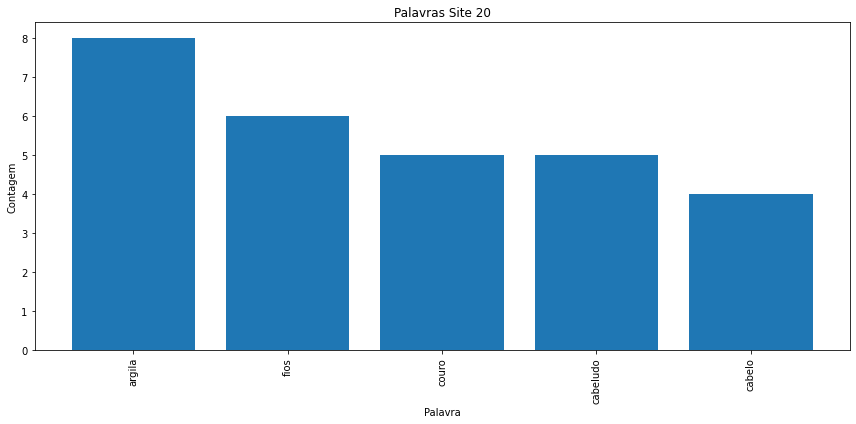

In [96]:
# Filtrando palavras com contagem acima de 2
palavras_filtrada_site20 = [palavras for palavras, count in zip(csv20['Palavra'], csv20['count']) if count > 2]
contagem_filtradas_site20 = [count for count in csv20['count'] if count > 2]

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(palavras_filtrada_site20, contagem_filtradas_site20)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Contagem')
plt.title('Palavras Site 20')
plt.tight_layout()
plt.show()

**Conclusão:**

Os sites foram analisados com base na contagem de palavras-chave mais frequentes em seus conteúdos.
Os sites variam de palavras-chave mais comuns, mas a palavra "pele" e "argila" aparecem frequentemente em muitos deles.
Alguns sites possuem palavras-chave adicionais que são exclusivas ou mais frequentes em comparação com outros sites.


## Desempenho das Palavras-chave nos Sites 1 ao 10

O gráfico mostra como as palavras-chave estão distribuídas em cada site. A altura das barras representa a contagem das palavras-chave, permitindo uma comparação visual entre os sites.

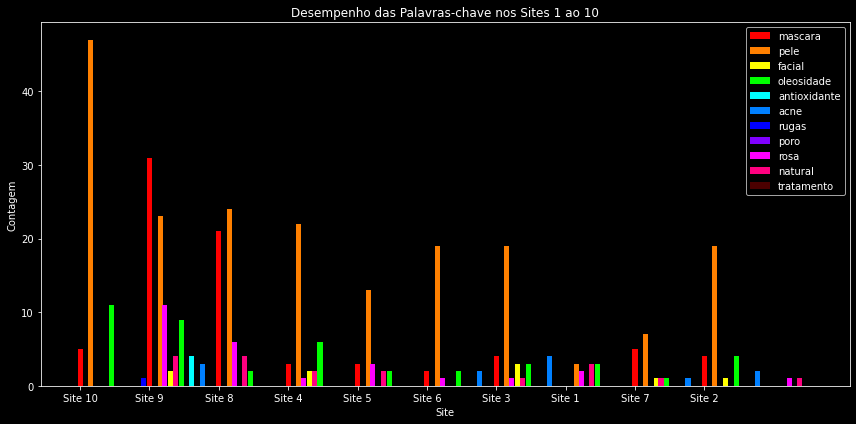

In [97]:
# Dados dos sites
dados_sites = [
    {'Site': 'Site 1', 'Dados': csv1},
    {'Site': 'Site 2', 'Dados': csv2},
    {'Site': 'Site 3', 'Dados': csv3},
    {'Site': 'Site 4', 'Dados': csv4},
    {'Site': 'Site 5', 'Dados': csv5},
    {'Site': 'Site 6', 'Dados': csv6},
    {'Site': 'Site 7', 'Dados': csv7},
    {'Site': 'Site 8', 'Dados': csv8},
    {'Site': 'Site 9', 'Dados': csv9},
    {'Site': 'Site 10', 'Dados': csv10},
]

# Palavras-chave para análise
palavras_chave = ["mascara", "pele", "facial", "oleosidade", "antioxidante",
                  "acne", "rugas", "poro",  "rosa", "natural",
                  "tratamento"]


# Definir cores personalizadas mais fortes
cores_personalizadas = ['#FF0000', '#FF8000', '#FFFF00', '#00FF00', '#00FFFF', '#0080FF',
                       '#0000FF', '#8000FF', '#FF00FF', '#FF0080', '#4C0000', '#4C8000',
                       '#4CFF00', '#004C00', '#004C50', '#004C80']

# Definir estilo de fundo preto
plt.style.use('dark_background')

# Organizar os dados em ordem decrescente
dados_ordenados = sorted(dados_sites[:10], key=lambda x: sum(x['Dados']['count']), reverse=True)

# Criar o gráfico de barras
plt.figure(figsize=(12, 6))

# Definir espaçamento das barras
bar_width = 0.8 / len(palavras_chave)
bar_spacing = 0.08

# Plotar as barras
for i, palavra in enumerate(palavras_chave):
    cor = cores_personalizadas[i % len(cores_personalizadas)]  # Selecionar cor apropriada
    contagem_site = [site['Dados'].loc[site['Dados']['Palavra'] == palavra, 'count'].values[0] if not site['Dados'].empty and palavra in site['Dados']['Palavra'].values else 0 for site in dados_ordenados]  # Considerar apenas os 10 primeiros sites
    index = np.arange(10) + (i * bar_width) + (i * bar_spacing)  # Considerar apenas os 10 primeiros sites
    plt.bar(index, contagem_site, bar_width, label=palavra, color=cor)

plt.xlabel('Site')
plt.ylabel('Contagem')
plt.title('Desempenho das Palavras-chave nos Sites 1 ao 10')
plt.xticks(np.arange(10), [site['Site'] for site in dados_ordenados])  # Considerar apenas os 10 primeiros sites
plt.legend()
plt.tight_layout()
plt.show()

Porcentagem de cada palavra-chave em relação ao total de contagens palavras-chave mais predominantes em todos os 10 sites analisados. Cada fatia representa uma palavra-chave e mostra a porcentagem correspondente total, trazendo assim o site mais relevante entre os 10 mais.

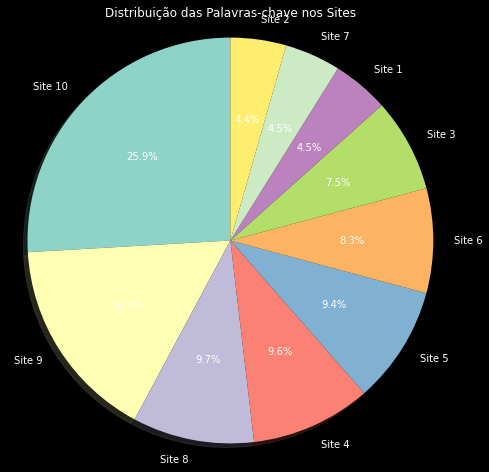

In [98]:
# Preparar os dados para o gráfico
contagens = [site['Dados']['count'].sum() for site in dados_ordenados[:10]]
labels = [site['Site'] for site in dados_ordenados[:10]]

# Criar o gráfico
plt.figure(figsize=(8, 8))
plt.pie(contagens, labels=labels, autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Distribuição das Palavras-chave nos Sites')

# Exibir o gráfico
plt.axis('equal')
plt.show()

## Desempenho das Palavras-chave nos Sites 11 ao 20

Faz a Contagem do Desempenho das Palavras-chave nos Sites 11 ao 20 em ordem decrescente

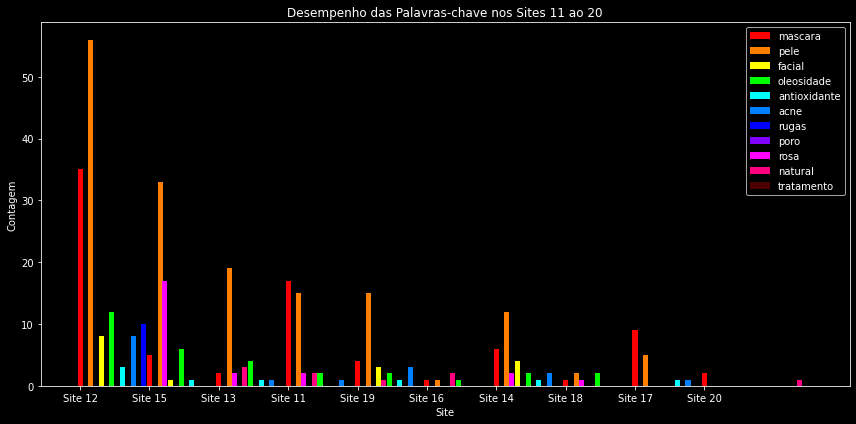

In [99]:
dados_sites_ultimos = [
    {'Site': 'Site 11', 'Dados': csv11},
    {'Site': 'Site 12', 'Dados': csv12},
    {'Site': 'Site 13', 'Dados': csv13},
    {'Site': 'Site 14', 'Dados': csv14},
    {'Site': 'Site 15', 'Dados': csv15},
    {'Site': 'Site 16', 'Dados': csv16},
    {'Site': 'Site 17', 'Dados': csv17},
    {'Site': 'Site 18', 'Dados': csv18},
    {'Site': 'Site 19', 'Dados': csv19},
    {'Site': 'Site 20', 'Dados': csv20},
]

# Palavras-chave para análise
chave = ["mascara", "pele", "facial", "oleosidade", "antioxidante",
                  "acne", "rugas", "poro",  "rosa", "natural",
                  "tratamento"]


# Definir cores personalizadas mais fortes
cores_pers = ['#FF0000', '#FF8000', '#FFFF00', '#00FF00', '#00FFFF', '#0080FF',
                       '#0000FF', '#8000FF', '#FF00FF', '#FF0080', '#4C0000', '#4C8000',
                       '#4CFF00', '#004C00', '#004C50', '#004C80']

# Definir estilo de fundo preto
plt.style.use('dark_background')

# Organizar os dados em ordem decrescente
df_ordenados = sorted(dados_sites_ultimos[:10], key=lambda x: sum(x['Dados']['count']), reverse=True)

# Criar o gráfico de barras
plt.figure(figsize=(12, 6))

# Definir espaçamento das barras
bar_width = 0.8 / len(chave)
bar_spacing = 0.08

# Plotar as barras
for i, palavra in enumerate(chave):
    cor = cores_pers[i % len(cores_pers)]  # Selecionar cor apropriada
    contagem_ultimo_site = [site['Dados'].loc[site['Dados']['Palavra'] == palavra, 'count'].values[0] if not site['Dados'].empty and palavra in site['Dados']['Palavra'].values else 0 for site in df_ordenados]  # Considerar apenas os 10 primeiros sites
    index = np.arange(10) + (i * bar_width) + (i * bar_spacing)  # Considerar apenas os 10 primeiros sites
    plt.bar(index, contagem_ultimo_site, bar_width, label=palavra, color=cor)

plt.xlabel('Site')
plt.ylabel('Contagem')
plt.title('Desempenho das Palavras-chave nos Sites 11 ao 20')
plt.xticks(np.arange(10), [site['Site'] for site in df_ordenados])  # Considerar apenas os 10 primeiros sites
plt.legend()
plt.tight_layout()
plt.show()

Porcentagem de cada palavra-chave em relação ao total de contagens palavras-chave mais predominantes em todos os outros 10 sites analisados. Cada fatia representa uma palavra-chave e mostra a porcentagem correspondente total, trazendo assim o site mais relevante entre os 11 a 20.

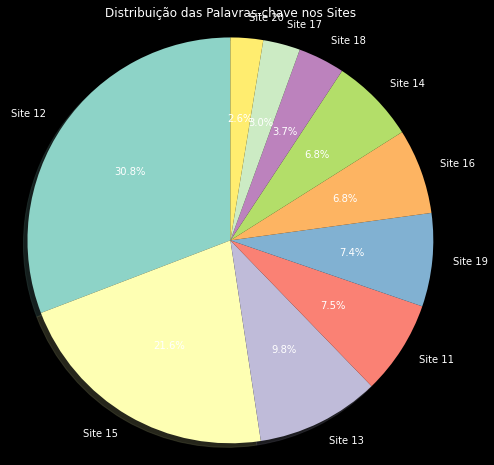

In [100]:
# Preparar os dados para o gráfico
contagen = [site['Dados']['count'].sum() for site in df_ordenados[:10]]
labels = [site['Site'] for site in df_ordenados[:10]]

# Criar o gráfico
plt.figure(figsize=(8, 8))
plt.pie(contagen, labels=labels, autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Distribuição das Palavras-chave nos Sites')

# Exibir o gráfico
plt.axis('equal')
plt.show()

## Desempenho e distribuição das Palavras-chave nos Sites Relavantes de Alta Performa

Juntando os melhores sites de alta performa

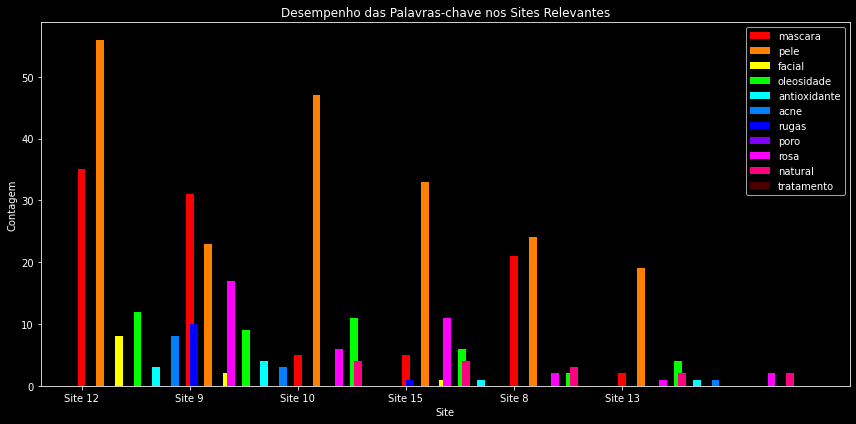

In [101]:
dados_sites_refin = [
    {'Site': 'Site 10', 'Dados': csv10},
    {'Site': 'Site 9', 'Dados': csv9},
    {'Site': 'Site 8', 'Dados': csv8},
    {'Site': 'Site 12', 'Dados': csv12},
    {'Site': 'Site 15', 'Dados': csv15},
    {'Site': 'Site 13', 'Dados': csv13}
]

chaves = ["mascara", "pele", "facial", "oleosidade", "antioxidante", "acne", "rugas", "poro", "rosa", "natural", "tratamento"]
cores = ['#FF0000', '#FF8000', '#FFFF00', '#00FF00', '#00FFFF', '#0080FF', '#0000FF', '#8000FF', '#FF00FF', '#FF0080', '#4C0000', '#4C8000', '#4CFF00', '#004C00', '#004C50', '#004C80']

plt.style.use('dark_background')

# Calculate the sum of counts for the selected keywords on each site
site_sums = []
for site in dados_sites_refin:
    site_data = site['Dados']
    if not site_data.empty:
        site_sum = site_data.loc[site_data['Palavra'].isin(chaves), 'count'].sum()
    else:
        site_sum = 0
    site_sums.append(site_sum)

# Sort the data based on the sum of counts
dados_ordenados = [x for _, x in sorted(zip(site_sums, dados_sites_refin), reverse=True)]

# Extract the data for the selected keywords and sites
dados_sites = []
for site in dados_ordenados:
    site_data = site['Dados']
    if not site_data.empty:
        site_counts = [site_data.loc[site_data['Palavra'] == palavra, 'count'].values[0] if palavra in site_data['Palavra'].values else 0 for palavra in chaves]
    else:
        site_counts = [0] * len(chaves)
    dados_sites.append(site_counts)

# Create the bar chart
plt.figure(figsize=(12, 6))

bar_width = 0.8 / len(chaves)
bar_spacing = 0.1

for i, palavra in enumerate(chaves):
    cor = cores[i % len(cores)]
    index = np.arange(len(dados_ordenados)) + (i * bar_width) + (i * bar_spacing)
    plt.bar(index, [site[i] for site in dados_sites], bar_width, label=palavra, color=cor)

plt.xlabel('Site')
plt.ylabel('Contagem')
plt.title('Desempenho das Palavras-chave nos Sites Relevantes')
plt.xticks(np.arange(len(dados_ordenados)), [site['Site'] for site in dados_ordenados])
plt.legend()
plt.tight_layout()
plt.show()

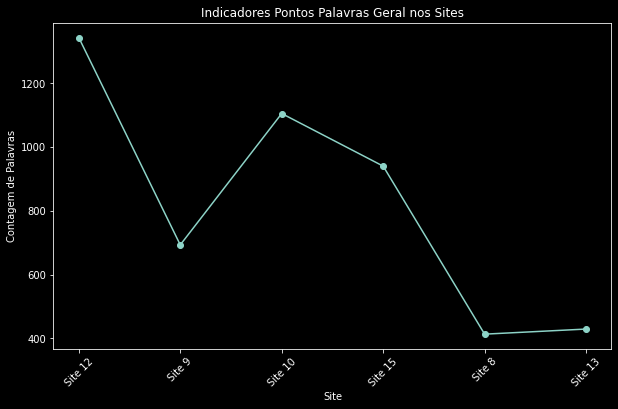

In [102]:
# Preparar os dados para o gráfico de linha
contagens = [site['Dados']['count'].sum() for site in dados_ordenados[:7]]
labels = [site['Site'] for site in dados_ordenados[:7]]

# Criar o gráfico de linha
plt.figure(figsize=(10, 6))
plt.plot(labels, contagens, marker='o')

# Personalizar o gráfico de linha
plt.xlabel('Site')
plt.ylabel('Contagem de Palavras')
plt.title('Indicadores Pontos Palavras Geral nos Sites')
plt.xticks(rotation=45)

# Exibir o gráfico
plt.show()

Faz a distribuição final das palavras-chave armazenada dados_sites analisando o desempenho dos sites relevante final.


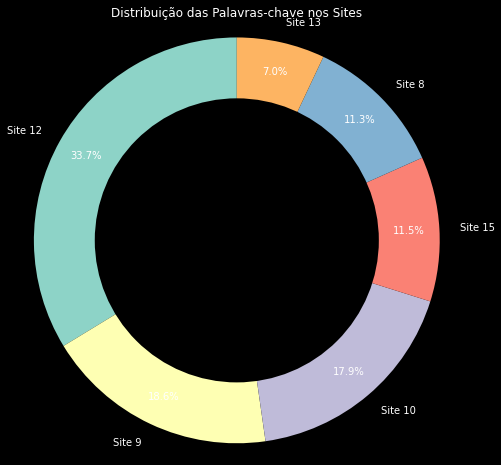

In [103]:
# Preparar os dados para o gráfico
contagens = [sum(site) for site in dados_sites[:7]]

# Criar o gráfico de rosca
plt.figure(figsize=(8, 8))
plt.pie(contagens, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
plt.title('Distribuição das Palavras-chave nos Sites')

# Adicionar círculo central para transformar em rosca
circle = plt.Circle((0, 0), 0.70, fc='black')
plt.gca().add_artist(circle)

# Ajustar as cores
plt.setp(plt.gca().texts, color='white')
plt.setp(plt.gca().collections, color='black', edgecolor='black')

# Ajustar o fundo do gráfico
plt.gca().set_facecolor('white')

# Exibir o gráfico
plt.axis('equal')
plt.show()

Faz a distribuição final das palavras-chave armazenada dados_sites analisando o desempenho dos sites relevante final.

Selecionar os top 6 sites com base na contagem

In [106]:
def plot_top6_sites(dados_sites, labels):
    # Selecionar os top 5 sites com base na contagem
    top6_sites = dados_sites[:6]

    # Extrair as contagens dos sites
    contagens = [sum(site) for site in top6_sites]

    # Cores para os diferentes níveis do pódio
    cores = ['gold', 'silver', 'brown', 'green', 'blue', 'purple']

    # Criar o gráfico de barras
    plt.figure(figsize=(10, 8))
    plt.bar(labels[:6], contagens, color=cores)

    # Adicionar os valores acima das barras
    for i, valor in enumerate(contagens):
        plt.text(i, valor, str(valor), ha='center', va='bottom')

    # Ajustar o fundo do gráfico
    plt.gca().set_facecolor('white')

    # Remover bordas do gráfico
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Adicionar título e rótulos dos eixos
    plt.title('Desempenho dos Top 6 Sites')
    plt.xlabel('Sites')
    plt.ylabel('Contagem de Palavras-chave')

    # Exibir o gráfico
    plt.show()

Selecionando os cinco melhores sites final

Valores dos cinco melhores sites em um podium com as palavras-chave selecionada na pesquisa, (site-11 ouro, site-12 prata e site-7 bronze, etc...).

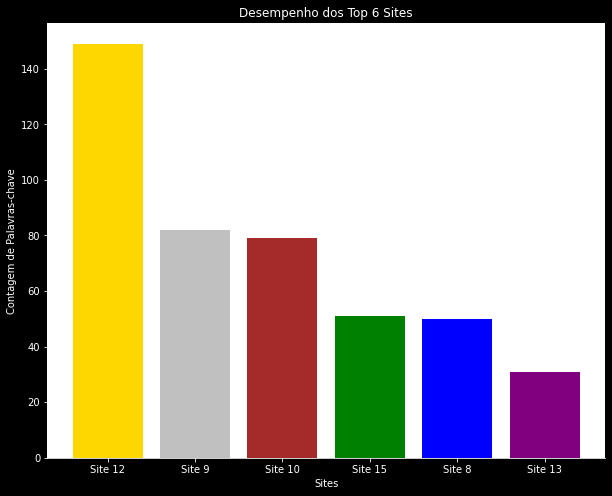

In [107]:
plot_top6_sites(dados_sites, labels)

**Relatório Geral - Análise de Palavras-chave nos Sites**

Este relatório apresenta uma análise das palavras-chave em diferentes sites. Foram coletados dados de contagem de palavras-chave em um total de 20 sites. O objetivo é identificar as palavras-chave mais relevantes e sua distribuição nos sites analisados.

Palavras-chave mais relevantes:
As seguintes palavras-chave foram identificadas como as mais relevantes com base na contagem em todos os sites analisados:

argila
pele
mascara
oleosidade
brasileira
importante
vermelha
mascaras
argilas
indicamos

Essas palavras-chave são frequentemente mencionadas nos sites e podem ser consideradas como tópicos importantes relacionados ao tema analisado.

Distribuição das palavras-chave nos sites:
A distribuição das palavras-chave nos 20 sites analisados pode ser visualizada no gráfico de barras a seguir. O eixo x representa os sites e o eixo y representa a contagem das palavras-chave.

O gráfico de barras mostra como as palavras-chave estão distribuídas em cada site. A altura das barras representa a contagem das palavras-chave, permitindo uma comparação visual entre os sites.

Distribuição geral das palavras-chave:
Além disso, a distribuição geral das palavras-chave em todos os sites pode ser visualizada no gráfico de pizza a seguir. O gráfico de pizza mostra a porcentagem de cada palavra-chave em relação ao total de contagens.

O gráfico de pizza destaca as palavras-chave mais predominantes em todos os sites analisados. Cada fatia representa uma palavra-chave e mostra a porcentagem correspondente.

Conclusão:

Com base na análise das palavras-chave nos sites, podemos identificar os principais tópicos de interesse relacionados ao tema analisado. As palavras-chave mais relevantes, como "argila", "pele" e "mascara", são frequentemente mencionadas nos sites. Essas informações podem ser úteis para entender a ênfase dada a cada tópico e auxiliar em estratégias de otimização de conteúdo para os sites analisados.